#Goal: We wanted to identify foods or categories that are compositionally dissimilar despite being labeled together, and to show which labels can be regrouped to better represent food composition.


## Questions:

*   How do we group related foods together? (Set 1)
*   How do these groups compare to grouping by composition? (Set 1)
*   How does this apply to nutrient subsets? (Set 2)
*   How do superfoods compared to subjective or composition labeling (Set 3)


###Loading in Data

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
drive_csv_id = '1KVSTXSnCXLxbFWa5CG7BF5qMpklFhrWx'

In [0]:
downloaded = drive.CreateFile({'id':drive_csv_id})   # replace the id with id of file you want to access
downloaded.GetContentFile('usda-grp-nomiss.csv')        # replace the file name with your file

In [0]:
import pandas as pd
df = pd.read_csv('usda-grp-nomiss.csv')

In [0]:
df

Unnamed: 0  NDB_No  ...                          GmWt_Desc2 Refuse_Pct
0              1    1001  ...                              1 tbsp          0
1              2    1002  ...                              1 tbsp          0
2              3    1003  ...                              1 tbsp          0
3              4    1004  ...                        1 cubic inch          0
4              5    1005  ...                     1 cup, shredded          0
...          ...     ...  ...                                 ...        ...
1831        8175   43599  ...                               1 cup          0
1832        8176   44005  ...                          1 teaspoon          0
1833        8180   44061  ...  1 package,  1.4 oz box, 4 servings          0
1834        8185   44258  ...                           1 package          0
1835        8187   44260  ...              1 package,  4 servings          0

[1836 rows x 56 columns]

### Preprocessing: Reducing food groups

We reduced the number of food groups from 24 to 19 by combining subjectively: Meats, Meals, and Produce

In [0]:
df['FdGrp_Desc'].unique()

array(['Dairy and Egg Products', 'Spices and Herbs', 'Baby Foods',
       'Fats and Oils', 'Poultry Products', 'Soups, Sauces, and Gravies',
       'Sausages and Luncheon Meats', 'Breakfast Cereals',
       'Fruits and Fruit Juices', 'Pork Products',
       'Vegetables and Vegetable Products', 'Nut and Seed Products',
       'Beef Products', 'Beverages', 'Finfish and Shellfish Products',
       'Legumes and Legume Products', 'Lamb, Veal, and Game Products',
       'Baked Products', 'Snacks', 'Sweets', 'Cereal Grains and Pasta',
       'Fast Foods', 'Meals, Entrees, and Sidedishes', 'Restaurant Foods'],
      dtype=object)

In [0]:
len(df['FdGrp_Desc'].unique())

24

In [0]:
foods = df[df['Shrt_Desc'].str.contains('AVOCADO')]
foods

Unnamed: 0  NDB_No  ...                      GmWt_Desc2 Refuse_Pct
477        2175    9037  ...                   1 cup, pureed         26
478        2176    9038  ...  1 fruit, without skin and seed         33

[2 rows x 56 columns]

In [0]:
0# Creating 'Meat' group
reduced_df = df.copy()
reduced_df.loc[reduced_df['FdGrp_Desc'] == 'Poultry Products', 'FdGrp_Desc'] = 'Meat'
reduced_df.loc[reduced_df['FdGrp_Desc'] == 'Beef Products', 'FdGrp_Desc'] = 'Meat'
reduced_df.loc[reduced_df['FdGrp_Desc'] == 'Pork Products', 'FdGrp_Desc'] = 'Meat'
reduced_df.loc[reduced_df['FdGrp_Desc'] == 'Lamb, Veal, and Game Products', 'FdGrp_Desc'] = 'Meat'


In [0]:
#creaing 'meals' group
reduced_df.loc[reduced_df['FdGrp_Desc'] == 'Meals, Entrees, and Sidedishes', 'FdGrp_Desc'] = 'Meals'
reduced_df.loc[reduced_df['FdGrp_Desc'] == 'Restaurant Foods', 'FdGrp_Desc'] = 'Meals'


In [0]:
#creating fruits and vegetable group
reduced_df.loc[reduced_df['FdGrp_Desc'] == 'Fruits and Fruit Juices', 'FdGrp_Desc'] = 'Produce'
reduced_df.loc[reduced_df['FdGrp_Desc'] == 'Vegetables and Vegetable Products', 'FdGrp_Desc'] = 'Produce'


In [0]:
len(reduced_df['FdGrp_Desc'].unique())

19

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
%config InlineBackend.figure_format='retina'
import altair as alt
import matplotlib.pyplot as plt
import plotly.express as px


### Baseline (non-reduced)

In [0]:
key = list(df['FdGrp_Desc'].unique())
value = np.arange(24)
label_dict = dict(zip(key, value))
df['label'] = df['FdGrp_Desc'].map(label_dict)

In [0]:
df['label']

0        0
1        0
2        0
3        0
4        0
        ..
1831     3
1832     3
1833    19
1834    19
1835    19
Name: label, Length: 1836, dtype: int64

In [0]:
labels = np.array(df['label'])
x_macro = df[macro]

In [0]:
x_macro.head()

Protein  Lipid_Tot   Ash  Carbohydrt  Fiber_TD  Sugar_Tot
0     0.85      81.11  2.11        0.06       0.0       0.06
1     0.85      81.11  2.11        0.06       0.0       0.06
2     0.28      99.48  0.00        0.00       0.0       0.00
3    21.40      28.74  5.11        2.34       0.0       0.50
4    23.24      29.68  3.18        2.79       0.0       0.51

In [0]:
kmeans = KMeans(n_clusters=24)
kmeans.fit(x_macro, labels)
labels_macro = kmeans.predict(x_macro)
accuracy_macro = np.mean(labels_macro == labels)

In [0]:
print("accuracy for macronutrients ", accuracy_macro)

accuracy for macronutrients  0.07679738562091504


### Baseline (reduced)

In [0]:
key = list(reduced_df['FdGrp_Desc'].unique())
value = np.arange(24)
label_dict = dict(zip(key, value))
reduced_df['label'] = reduced_df['FdGrp_Desc'].map(label_dict)

In [0]:
labels = np.array(reduced_df['label'])
x_macro = reduced_df[macro]

In [0]:
kmeans = KMeans(n_clusters=24)
kmeans.fit(x_macro, labels)
labels_macro = kmeans.predict(x_macro)
accuracy_macro = np.mean(labels_macro == labels)
print("accuracy for macronutrients ", accuracy_macro)

accuracy for macronutrients  0.013071895424836602


### With PCA

In [0]:
scaler = StandardScaler()
x_macro = scaler.fit_transform(x_macro)
pca_macro = PCA(n_components=5)
pca_macro.fit(x_macro)
print(sum(pca_macro.explained_variance_ratio_))
reduced_macro = pca_macro.fit_transform(x_macro)

0.9649586953759683


In [0]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(reduced_macro, labels)
labels_macro = kmeans.predict(reduced_macro)
accuracy_macro = np.mean(labels_macro == labels)

In [0]:
print("accuracy for macronutrients ", accuracy_macro)

accuracy for macronutrients  0.04411764705882353


### With TSN-E

In [0]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x_macro)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1836 samples in 0.002s...
[t-SNE] Computed neighbors for 1836 samples in 0.083s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1836
[t-SNE] Computed conditional probabilities for sample 1836 / 1836
[t-SNE] Mean sigma: 0.197298
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.394848
[t-SNE] KL divergence after 300 iterations: 0.744755


##Set 1

### 1. Cluster identification. Is it possible to group the foods into distinct clusters according to how similar they are across all macronutrients, vitamins and minerals quantities recorded in the data?

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%config InlineBackend.figure_format='retina'
import altair as alt
import matplotlib.pyplot as plt
import plotly.express as px


In [0]:
#reducing total amount of features to only macros, minerals, and vits
num_features = ['Water', 'Carbohydrt', 'FA_Sat', 'FA_Mono', 'FA_Poly', 'Protein', 'Sodium', 'Potassium', 'Manganese', 'Zinc', 'Calcium', 'Iron', 'Phosphorus', 'Magnesium', 'Copper']
list1 = [col for col in df if col.startswith('Vit')]
num_features = num_features + list1

In [0]:
''' Here we simply convert non-numeric values into 0 '''
# this step change strings into NaN
processed = reduced_df[num_features].apply(pd.to_numeric, errors="coerce")

# then we change NaN to 0
processed = processed.replace(np.nan,0)
processed

Water  Carbohydrt  FA_Sat  FA_Mono  ...  Vit_E  Vit_D  Vit_D.1  Vit_K
0     15.87        0.06  51.368   21.021  ...   2.32    1.5       60    7.0
1     15.87        0.06  50.489   23.426  ...   2.32    1.5       60    7.0
2      0.24        0.00  61.924   28.732  ...   2.80    1.8       73    8.6
3     42.41        2.34  18.669    7.778  ...   0.25    0.5       21    2.4
4     41.11        2.79  18.764    8.598  ...   0.26    0.5       22    2.5
...     ...         ...     ...      ...  ...    ...    ...      ...    ...
1831  39.90       23.90   5.000    9.000  ...   2.06    0.0        0   42.2
1832   0.00        0.00  14.367   48.033  ...  14.78    0.0        0   21.0
1833   4.20       78.20   0.984    1.154  ...   0.02    0.0        0    0.4
1834   6.80       74.42   1.578    1.150  ...   0.02    0.0        0    0.5
1835   6.84       84.66   0.099    0.116  ...   0.08    0.0        0    1.7

[1836 rows x 24 columns]

In [0]:
for column in processed:
  processed[column] = processed[column]/processed[column].max()

processed

Water  Carbohydrt    FA_Sat  ...     Vit_D   Vit_D.1     Vit_K
0     0.158859    0.000600  0.593829  ...  0.053381  0.053428  0.004083
1     0.158859    0.000600  0.583668  ...  0.053381  0.053428  0.004083
2     0.002402    0.000000  0.715860  ...  0.064057  0.065004  0.005016
3     0.424525    0.023405  0.215819  ...  0.017794  0.018700  0.001400
4     0.411512    0.027906  0.216917  ...  0.017794  0.019590  0.001458
...        ...         ...       ...  ...       ...       ...       ...
1831  0.399399    0.239048  0.057801  ...  0.000000  0.000000  0.024614
1832  0.000000    0.000000  0.166087  ...  0.000000  0.000000  0.012248
1833  0.042042    0.782156  0.011375  ...  0.000000  0.000000  0.000233
1834  0.068068    0.744349  0.018242  ...  0.000000  0.000000  0.000292
1835  0.068468    0.846769  0.001144  ...  0.000000  0.000000  0.000992

[1836 rows x 24 columns]

#### K-Means -> TSNE

##### k means

([<matplotlib.axis.XTick at 0x7fbfe3462c50>,
 <a list of 14 Text major ticklabel objects>)

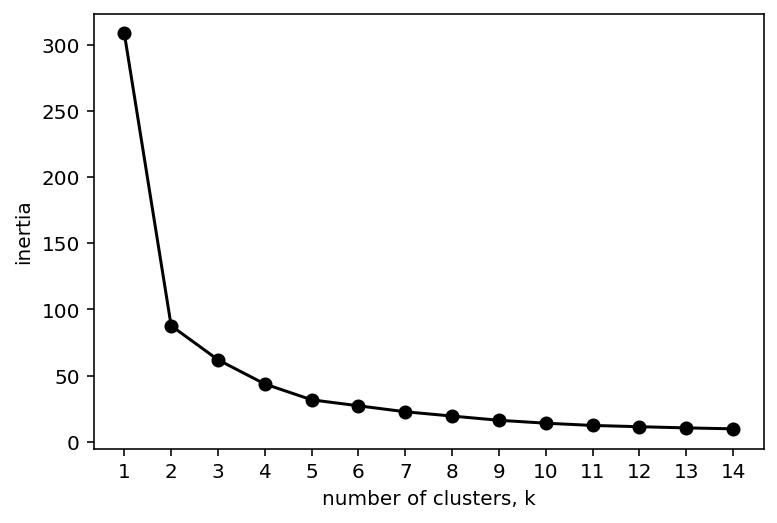

In [0]:
#@@@@@
ks = range(1, 15)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(processed.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)

In [0]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)

In [0]:
kmeans.fit(processed)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [0]:
df_kmeans = pd.concat([reduced_df.reset_index(drop = True), pd.DataFrame(processed)], axis = 1)
df_kmeans.columns.values[-3:] = ['Component 1', 'Compenent 2', 'Component 3']
df_kmeans['K-Means'] = kmeans.labels_
df_kmeans

Unnamed: 0  NDB_No  FdGrp_CD  ... Compenent 2 Component 3  K-Means
0              1    1001       100  ...    0.053428    0.004083        3
1              2    1002       100  ...    0.053428    0.004083        3
2              3    1003       100  ...    0.065004    0.005016        3
3              4    1004       100  ...    0.018700    0.001400        0
4              5    1005       100  ...    0.019590    0.001458        0
...          ...     ...       ...  ...         ...         ...      ...
1831        8175   43599       400  ...    0.000000    0.024614        0
1832        8176   44005       400  ...    0.000000    0.012248        3
1833        8180   44061      1900  ...    0.000000    0.000233        1
1834        8185   44258      1900  ...    0.000000    0.000292        1
1835        8187   44260      1900  ...    0.000000    0.000992        1

[1836 rows x 82 columns]

##### T-SNE

In [0]:
''' prepare the features for be analyszed '''
X = processed[num_features].values
result_tsne = TSNE(n_components=2,perplexity=50).fit_transform(X)

'''
X = processed[num_features].values
result_tsne = TSNE(n_components=2).fit_transform(X)
'''

'\nX = processed[num_features].values\nresult_tsne = TSNE(n_components=2).fit_transform(X)\n'

In [0]:
tsne_df = pd.DataFrame(data=result_tsne, columns=['x','y'])

alt.Chart(tsne_df).mark_point().encode(
    x='x:Q',
    y='y:Q',
)

alt.Chart(...)

In [0]:
tsne_df['Cluster'] = df_kmeans['K-Means']
tsne_df['Food_Group'] = reduced_df['FdGrp_Desc']
tsne_df['Food_Description'] = df['Shrt_Desc']

In [0]:
tsne1 = alt.Chart(tsne_df).mark_circle().encode(
    x='x:Q',
    y='y:Q',
    color='Cluster:N',
    tooltip=['Cluster', 'Food_Group', 'Food_Description']
)
tsne1

alt.Chart(...)

In [0]:
square = tsne_df[(tsne_df['x'] > -20) & (tsne_df['x'] < 30) & (tsne_df['y'] > -30) & (tsne_df['y'] < 0)]

In [0]:
squares = square['Food_Group'].unique()
tsne_squares = tsne_df[tsne_df['Food_Group'].isin(squares)]


In [0]:
tsnesquare = alt.Chart(square).mark_circle().encode(
    x='x:Q',
    y='y:Q',
    color='Food_Group:N',
    tooltip=['Cluster', 'Food_Group', 'Food_Description']
)
tsnesquare

alt.Chart(...)

In [0]:
# tsne2a = alt.Chart(tsne_dfpt1).mark_circle().encode(
#     x='x:Q',
#     y='y:Q',
#     color='Food_Group:N',
#     tooltip=['Cluster', 'Food_Group', 'Food_Description']
# )
# tsne2b = alt.Chart(tsne_dfpt2).mark_circle().encode(
#     x='x:Q',
#     y='y:Q',
#     color='Food_Group:N',
#     tooltip=['Cluster', 'Food_Group', 'Food_Description']
# )
# tsne2a 

alt.Chart(...)

In [0]:
# tsne2b

alt.Chart(...)

In [0]:
tsne2 = alt.Chart(tsne_df).mark_circle().encode(
    x='x:Q',
    y='y:Q',
    color='Food_Group:N',
    tooltip=['Cluster', 'Food_Group', 'Food_Description']
)
tsne2

alt.Chart(...)

#### TSNE -> Kmeans

In [0]:
tsne_df_2 = pd.DataFrame(data=result_tsne, columns=['x','y'])
tsne_df_2

x          y
0    -25.894287   3.991596
1    -25.850336   3.961486
2    -26.201504   3.860793
3    -25.146389  11.923061
4    -25.726023  11.725002
...         ...        ...
1831 -18.679113  -1.558742
1832 -24.623869  -1.029858
1833 -35.096272 -30.454992
1834 -35.127651 -27.539581
1835 -30.230007 -33.720684

[1836 rows x 2 columns]

([<matplotlib.axis.XTick at 0x7fbfe2d63f98>,
 <a list of 14 Text major ticklabel objects>)

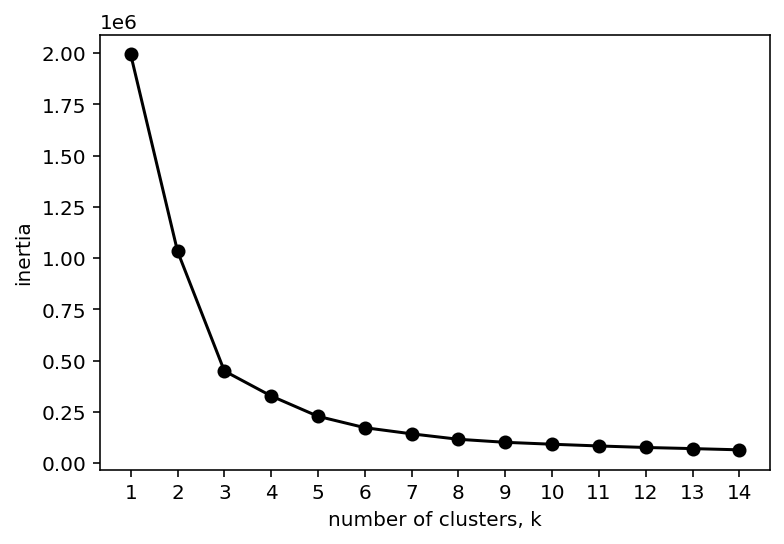

In [0]:
#@@@@@
ks = range(1, 15)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(tsne_df_2.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)

In [0]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)

In [0]:
kmeans.fit(tsne_df_2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [0]:
df_kmeans2 = pd.concat([reduced_df.reset_index(drop = True), pd.DataFrame(tsne_df_2)], axis = 1)
df_kmeans2.columns.values[-3:] = ['Component 1', 'Compenent 2', 'Component 3']
tsne_df_2['K-Means'] = kmeans.labels_
tsne_df_2

x          y  K-Means
0    -25.894287   3.991596        2
1    -25.850336   3.961486        2
2    -26.201504   3.860793        2
3    -25.146389  11.923061        0
4    -25.726023  11.725002        0
...         ...        ...      ...
1831 -18.679113  -1.558742        2
1832 -24.623869  -1.029858        2
1833 -35.096272 -30.454992        2
1834 -35.127651 -27.539581        2
1835 -30.230007 -33.720684        2

[1836 rows x 3 columns]

In [0]:
tsne_df_2['Cluster'] = df_kmeans['K-Means']
tsne_df_2['Food_Group'] = reduced_df['FdGrp_Desc']
tsne_df_2['Food_Description'] = df['Shrt_Desc']

In [0]:
tsne3 = alt.Chart(tsne_df_2).mark_circle().encode(
    x='x:Q',
    y='y:Q',
    color='K-Means:N',
    tooltip=['Cluster', 'Food_Group', 'Food_Description']

)

### 2. Clusters vs. labels. Once a set of clusters has been found, how do the clusters compare to the food groups recorded in the data (e.g., Poultry, Dairy and Egg, Fruits) (see the field “FdGrp_Desc”)? Do food belonging to the same food group fall in the same clusters? Are there foods that belong to the same food group but fall into different clusters (that is, same food group but different food composition)? Are there foods that belong to different groups but fall into the same cluster (that is, different food groups but similar food composition)?


In [0]:
tsne3

alt.Chart(...)

In [0]:
#tsne1 = clustered with k means on high dimension, then reduced dimension with tsne
tsne1 | tsne3 | tsne2

alt.HConcatChart(...)

### 3. Outliers. Are there any foods that tend to be different from all the others (that is, they are outliers)? What is unique about them? What makes them unique?


In [0]:
test = tsne_df[['Cluster', 'Food_Group']]
check = test.groupby('Food_Group')['Cluster'].value_counts().reset_index(name='Counts')
check

Food_Group  Cluster  Counts
0                       Baby Foods        2      45
1                       Baby Foods        1       2
2                       Baby Foods        0       1
3                   Baked Products        1     208
4                   Baked Products        0       7
5                   Baked Products        2       7
6                   Baked Products        3       1
7                        Beverages        2      71
8                        Beverages        1      13
9                        Beverages        0       1
10               Breakfast Cereals        1      16
11               Breakfast Cereals        2       8
12               Breakfast Cereals        3       1
13         Cereal Grains and Pasta        2       3
14         Cereal Grains and Pasta        1       2
15          Dairy and Egg Products        2      58
16          Dairy and Egg Products        0      50
17          Dairy and Egg Products        1      12
18          Dairy and Egg Products        3       7
19                      Fast Foods        0      15
20                      Fast Foods        1       3
21                   Fats and Oils        3      20
22                   Fats and Oils        2      15
23                   Fats and Oils        0       6
24                   Fats and Oils        1       2
25  Finfish and Shellfish Products        0      80
26  Finfish and Shellfish Products        2      14
27     Legumes and Legume Products        2      21
28     Legumes and Legume Products        3      14
29     Legumes and Legume Products        1      12
30     Legumes and Legume Products        0       6
31                           Meals        0       6
32                           Meals        2       5
33                            Meat        0     381
34                            Meat        3       8
35                            Meat        2       2
36           Nut and Seed Products        3      41
37           Nut and Seed Products        1       5
38           Nut and Seed Products        2       2
39           Nut and Seed Products        0       1
40                         Produce        2     357
41                         Produce        1      15
42                         Produce        0       1
43                         Produce        3       1
44     Sausages and Luncheon Meats        0      38
45     Sausages and Luncheon Meats        2       1
46                          Snacks        1      33
47                          Snacks        3       2
48                          Snacks        0       1
49      Soups, Sauces, and Gravies        2      80
50      Soups, Sauces, and Gravies        1       7
51      Soups, Sauces, and Gravies        3       2
52                Spices and Herbs        1       7
53                Spices and Herbs        3       7
54                Spices and Herbs        2       6
55                          Sweets        1      87
56                          Sweets        2      15
57                          Sweets        0       2
58                          Sweets        3       2

In [0]:
alt.Chart(check).mark_bar().encode(
    y=alt.X('Food_Group', sort='-y'),
    x=alt.Y('Counts', stack='normalize'),
    color='Cluster:N'
)

alt.Chart(...)

In [0]:
check2 = test.groupby('Cluster')['Food_Group'].value_counts().reset_index(name='Counts')

In [0]:
check2_01 = check2[(check2['Cluster']==1)]

In [0]:
check2_01

Cluster                   Food_Group  Counts
15        1               Baked Products     208
16        1                       Sweets      87
17        1                       Snacks      33
18        1            Breakfast Cereals      16
19        1                      Produce      15
20        1                    Beverages      13
21        1       Dairy and Egg Products      12
22        1  Legumes and Legume Products      12
23        1   Soups, Sauces, and Gravies       7
24        1             Spices and Herbs       7
25        1        Nut and Seed Products       5
26        1                   Fast Foods       3
27        1                   Baby Foods       2
28        1      Cereal Grains and Pasta       2
29        1                Fats and Oils       2

In [0]:
alt.Chart(check2[(check2['Cluster']==0) & (check2['Counts']>2)]).mark_bar().encode(
    x=alt.X('Counts:Q', stack='normalize'),
    y=alt.Y('Cluster:O', sort='-y'),
    color='Food_Group:N',
    tooltip=['Food_Group']

)

alt.Chart(...)

In [0]:
alt.Chart(check2[(check2['Cluster']==1) & (check2['Counts']>2)]).mark_bar().encode(
    x=alt.X('Counts:Q', stack='normalize'),
    y=alt.Y('Cluster:O', sort='-y'),
    color='Food_Group:N',
    tooltip=['Food_Group']

)

alt.Chart(...)

In [0]:
check2[(check2['Cluster']==2) & (check2['Counts']>2)]

Cluster                      Food_Group  Counts
30        2                         Produce     357
31        2      Soups, Sauces, and Gravies      80
32        2                       Beverages      71
33        2          Dairy and Egg Products      58
34        2                      Baby Foods      45
35        2     Legumes and Legume Products      21
36        2                   Fats and Oils      15
37        2                          Sweets      15
38        2  Finfish and Shellfish Products      14
39        2               Breakfast Cereals       8
40        2                  Baked Products       7
41        2                Spices and Herbs       6
42        2                           Meals       5
43        2         Cereal Grains and Pasta       3

In [0]:
alt.Chart(check2[(check2['Cluster']==2) & (check2['Counts']>2)]).mark_bar().encode(
    x=alt.X('Counts:Q', stack='normalize'),
    y=alt.Y('Cluster:O', sort='-y'),
    color='Food_Group:N',
    tooltip=['Food_Group']

)

alt.Chart(...)

In [0]:
alt.Chart(check2[(check2['Cluster']==3) & (check2['Counts']>2)]).mark_bar().encode(
    x=alt.X('Counts:Q', stack='normalize'),
    y=alt.Y('Cluster:O', sort='-y'),
    color='Food_Group:N',
    tooltip=['Food_Group']

)

alt.Chart(...)

In [0]:
alt.Chart(check2[(check2['Cluster']==2)]).mark_bar().encode(
    x=alt.X('Counts:Q', stack='normalize'),
    y=alt.Y('Cluster:O', sort='-y'),
    color='Food_Group:N',
    tooltip=['Food_Group']

)

alt.Chart(...)

In [0]:
alt.Chart(check2[(check2['Cluster']==3)]).mark_bar().encode(
    x=alt.X('Counts:Q', stack='normalize'),
    y=alt.Y('Cluster:O', sort='-y'),
    color='Food_Group:N',
    tooltip=['Food_Group']

)

alt.Chart(...)

In [0]:
alt.Chart(check2_23).mark_bar().encode(
    x=alt.X('Counts:Q', stack='normalize'),
    y=alt.Y('Cluster:O', sort='-y'),
    color='Food_Group:N',
    tooltip=['Food_Group']

)

alt.Chart(...)

In [0]:
reduced_df

Unnamed: 0  NDB_No  ...  Refuse_Pct label
0              1    1001  ...           0     0
1              2    1002  ...           0     0
2              3    1003  ...           0     0
3              4    1004  ...           0     0
4              5    1005  ...           0     0
...          ...     ...  ...         ...   ...
1831        8175   43599  ...           0     3
1832        8176   44005  ...           0     3
1833        8180   44061  ...           0    15
1834        8185   44258  ...           0    15
1835        8187   44260  ...           0    15

[1836 rows x 57 columns]

In [0]:
processed_cluster = processed.copy()

In [0]:
processed_cluster

Water  Carbohydrt    FA_Sat  ...     Vit_D   Vit_D.1     Vit_K
0     0.158859    0.000600  0.593829  ...  0.053381  0.053428  0.004083
1     0.158859    0.000600  0.583668  ...  0.053381  0.053428  0.004083
2     0.002402    0.000000  0.715860  ...  0.064057  0.065004  0.005016
3     0.424525    0.023405  0.215819  ...  0.017794  0.018700  0.001400
4     0.411512    0.027906  0.216917  ...  0.017794  0.019590  0.001458
...        ...         ...       ...  ...       ...       ...       ...
1831  0.399399    0.239048  0.057801  ...  0.000000  0.000000  0.024614
1832  0.000000    0.000000  0.166087  ...  0.000000  0.000000  0.012248
1833  0.042042    0.782156  0.011375  ...  0.000000  0.000000  0.000233
1834  0.068068    0.744349  0.018242  ...  0.000000  0.000000  0.000292
1835  0.068468    0.846769  0.001144  ...  0.000000  0.000000  0.000992

[1836 rows x 24 columns]

In [0]:
processed_cluster['cluster'] = tsne_df['Cluster']
processed_cluster['group'] = reduced_df['FdGrp_Desc']
processed_cluster['description'] = reduced_df['Shrt_Desc']
processed_cluster['ID'] = reduced_df['NDB_No']

In [0]:
macros_list = ['Carbohydrt', 'FA_Sat', 'FA_Mono', 'FA_Poly', 'Protein']
minerals_list = ['Sodium', 'Potassium', 'Manganese', 'Zinc', 'Calcium', 'Iron', 'Phosphorus', 'Magnesium', 'Copper']
vitamins_list = [col for col in df if col.startswith('Vit')]


In [0]:
processed_cluster['macros'] = processed_cluster[macros_list].sum(axis=1)
processed_cluster = processed_cluster.drop(macros_list, axis = 1) 
processed_cluster['minerals'] = processed_cluster[minerals_list].sum(axis=1)
processed_cluster = processed_cluster.drop(minerals_list, axis = 1) 
processed_cluster['vitamins'] = processed_cluster[vitamins_list].sum(axis=1)
processed_cluster = processed_cluster.drop(vitamins_list, axis = 1) 

In [0]:
processed_cluster = processed_cluster[['ID','cluster', 'group', 'description', 'macros', 'minerals', 'vitamins' ]]
processed_cluster

ID  cluster                   group  ...    macros  minerals  vitamins
0      1001        3  Dairy and Egg Products  ...  0.908241  0.029581  0.389160
1      1002        3  Dairy and Egg Products  ...  0.926280  0.036325  0.387169
2      1003        3  Dairy and Egg Products  ...  1.126426  0.001474  0.464266
3      1004        0  Dairy and Egg Products  ...  0.596018  0.233983  0.195257
4      1005        0  Dairy and Egg Products  ...  0.632634  0.230955  0.210029
...     ...      ...                     ...  ...       ...       ...       ...
1831  43599        0           Fats and Oils  ...  0.726647  0.033535  0.097537
1832  44005        3           Fats and Oils  ...  1.312132  0.001668  0.372034
1833  44061        1                  Sweets  ...  0.871506  0.648607  0.007999
1834  44258        1                  Sweets  ...  0.896341  0.712169  0.005356
1835  44260        1                  Sweets  ...  0.866262  0.388924  0.006275

[1836 rows x 7 columns]

In [0]:
processed_cluster['group'].unique()

array(['Dairy and Egg Products', 'Spices and Herbs', 'Baby Foods',
       'Fats and Oils', 'Meat', 'Soups, Sauces, and Gravies',
       'Sausages and Luncheon Meats', 'Breakfast Cereals', 'Produce',
       'Nut and Seed Products', 'Beverages',
       'Finfish and Shellfish Products', 'Legumes and Legume Products',
       'Baked Products', 'Snacks', 'Sweets', 'Cereal Grains and Pasta',
       'Fast Foods', 'Meals'], dtype=object)

In [0]:
#“Dairy and Egg Products”, “Legumes and Legume Products”, “Fats and Oils”, “Spices and Herbs”, “Cereal Grains and Pasta”
dairy = processed_cluster[processed_cluster['group'] == 'Dairy and Egg Products']
legumes = processed_cluster[processed_cluster['group'] == 'Legumes and Legume Products']
fats = processed_cluster[processed_cluster['group'] == 'Fats and Oils']
spices = processed_cluster[processed_cluster['group'] == 'Spices and Herbs']
ffoods = processed_cluster[processed_cluster['group'] == 'Fast Foods']
grains = processed_cluster[processed_cluster['group'] == 'Cereal Grains and Pasta']
meats = processed_cluster[processed_cluster['group'] == 'Meat']

In [0]:
px.parallel_coordinates(meats, color='cluster', dimensions=['cluster','minerals', 'macros', 'vitamins'], 
                        color_continuous_scale=[(0.00, "blue"),   (0.25, "blue"),
                                                (0.25, "goldenrod"), (0.5, "goldenrod"),
                                                (0.5, "red"),  (.75, "red"),
                                                (0.75,"green"),(1,"green")],)

###### Dairy Clusters. Consistant Outliers: 

*   Outlier 1: vitamins: 1.6151 
*   Outlier 2: minerals: .95016
*   Outliers 3: minerals: .4 < x < .65, vitamins: 1 < x < 1.3



In [0]:
px.parallel_coordinates(dairy, color='cluster', dimensions=['cluster','minerals', 'macros', 'vitamins'], 
                        color_continuous_scale=[(0.00, "blue"),   (0.25, "blue"),
                                                (0.25, "goldenrod"), (0.5, "goldenrod"),
                                                (0.5, "red"),  (.75, "red"),
                                                (0.75,"green"),(1,"green")],)

###### Legume Clusters. Consistant Outliers: 

*   Outlier 1: minerals: > 1.43
*   Outlier 2: minerals: 1 < x < 1.2, vitamins: .75 < x < 1
*   Outlier 3: minerals: < .4, vitamins >  .2



In [0]:
px.parallel_coordinates(legumes, color='cluster', dimensions=['cluster','minerals', 'macros', 'vitamins'], 
                        color_continuous_scale=[(0.00, "blue"),   (0.25, "blue"),
                                                (0.25, "goldenrod"), (0.5, "goldenrod"),
                                                (0.5, "red"),  (.75, "red"),
                                                (0.75,"green"),(1,"green")],)

###### Fats Clusters. Consistant Outliers: 

*   Outlier 1: minerals: > .138
*   Outlier 2: minerals: .01 < x  < .03, vitamins: > .73



In [0]:
px.parallel_coordinates(fats, color='cluster', dimensions=['cluster','minerals', 'macros', 'vitamins'], 
                        color_continuous_scale=[(0.00, "red"),   (0.25, "red"),
                                                (0.25, "green"), (0.5, "green"),
                                                (0.5, "blue"),  (.75, "blue"),
                                                (0.75,"goldenrod"),(1,"goldenrod")],)

###### Spices Clusters. Consistant Outliers: 

*   Outlier 1: minerals: > 3.01
*   Outlier 2: macros: 0, vitamins: 0




In [0]:
px.parallel_coordinates(spices, color='cluster', dimensions=['cluster','minerals', 'macros', 'vitamins'], 
                        color_continuous_scale=[(0.00, "red"),   (0.25, "red"),
                                                (0.25, "green"), (0.5, "green"),
                                                (0.5, "blue"),  (.75, "blue"),
                                                (0.75,"goldenrod"),(1,"goldenrod")],)

###### Grains Clusters. Consistant Outliers: 

*   Outlier 1: minerals: > .2


In [0]:
px.parallel_coordinates(grains, color='cluster', dimensions=['cluster','minerals', 'macros', 'vitamins'], 
                        color_continuous_scale=[(0.00, "red"),   (0.25, "red"),
                                                (0.25, "green"), (0.5, "green"),
                                                (0.5, "blue"),  (.75, "blue"),
                                                (0.75,"goldenrod"),(1,"goldenrod")],)

##### Dairy Outliers
IDs: [1137, 1113, 1090, 1092, 1154]

In [0]:
DairyIDList=[]

In [0]:
DairyIDList.extend(dairy[dairy['vitamins']>1.6]['ID'].tolist())
DairyIDList.extend(dairy[dairy['minerals']>.94]['ID'].tolist())
DairyIDList.extend(dairy[(dairy['vitamins']>1) & (dairy['vitamins']<1.3) & (dairy['minerals']> .4) & (dairy['minerals']<.65) ]['ID'].tolist())
print(DairyIDList)

[]


In [0]:
DairyOutliers = dairy[dairy.ID.isin(DairyIDList)]
DairyOutliers

Empty DataFrame
Columns: [ID, cluster, group, description, macros, minerals, vitamins]
Index: []

Outliers for cluster 2 are heavy in macros.


##### Legumes Outliers
IDs: [16115, 16117, 16104]

In [0]:
LegumeIDList=[]

In [0]:
LegumeIDList=[]

LegumeIDList.extend(legumes[legumes['minerals']>1.43]['ID'].tolist())
LegumeIDList.extend(legumes[(legumes['minerals']>1) & (legumes['minerals']<1.2) & (legumes['vitamins']>.75) & (legumes['vitamins']<1)]['ID'].tolist())
LegumeIDList.extend(legumes[(legumes['minerals']<.4) & (legumes['vitamins']>.2)]['ID'].tolist())
print(LegumeIDList)

[16115, 16117, 16104]


In [0]:
LegumeOutliers = legumes[legumes.ID.isin(LegumeIDList)]
LegumeOutliers

ID  cluster                        group  ...    macros  minerals  vitamins
1284  16104        0  Legumes and Legume Products  ...  0.593612  0.137084  0.251900
1287  16115        3  Legumes and Legume Products  ...  1.046393  1.464479  0.170304
1288  16117        3  Legumes and Legume Products  ...  0.946248  1.500091  0.103903

[3 rows x 7 columns]

##### Fats Outliers
IDs: [42178, 4128]

In [0]:
FatsIDList=[]

In [0]:
FatsIDList.extend(fats[(fats['minerals']>.138)]['ID'].tolist())
FatsIDList.extend(fats[(fats['minerals']>.01) & (fats['minerals'] < 0.03) & (fats['vitamins'] > 0.73)]['ID'].tolist())
FatsIDList

[42178, 4128]

In [0]:
FatsOutliers = df[df.NDB_No.isin(FatsIDList)]
FatsOutliers

Unnamed: 0  NDB_No  FdGrp_CD  ... GmWt_Desc2 Refuse_Pct  label
206          618    4128       400  ...      1 cup          0      3
1811        7986   42178       400  ...      1 cup          0      3

[2 rows x 57 columns]

##### Spices Outliers
IDs: [2003, 2047]

In [0]:
SpicesIDList=[]

In [0]:

SpicesIDList.extend(spices[(spices['minerals']>3.0)]['ID'].tolist())
SpicesIDList.extend(spices[(spices['macros']==0) & (spices['vitamins'] == 0)]['ID'].tolist())
SpicesIDList

[2003, 2047]

In [0]:
SpicesOutliers = df[df.NDB_No.isin(SpicesIDList)]
SpicesOutliers

Unnamed: 0  NDB_No  FdGrp_CD  ...      GmWt_Desc2 Refuse_Pct  label
125         223    2003       200  ...  1 tbsp, leaves          0      1
140         266    2047       200  ...          1 tbsp          0      1

[2 rows x 57 columns]

##### Grains Outliers
IDs: [20099, 20109]

In [0]:
GrainsIDList=[]

In [0]:
GrainsIDList.extend(grains[(grains['minerals']>0.2)]['ID'].tolist())
GrainsIDList

[20099, 20109]

In [0]:
GrainsOutliers = df[df.NDB_No.isin(GrainsIDList)]
GrainsOutliers

Unnamed: 0  NDB_No  FdGrp_CD  ...            GmWt_Desc2 Refuse_Pct  label
1709        6327   20099      2000  ...  1 cup, spiral shaped          0     20
1711        6335   20109      2000  ...                  2 oz          0     20

[2 rows x 57 columns]

### Interpretation. For the clusters and outliers identified above, what aspects of their food composition make them different from the others and similar to the food that belong to the same cluster (that is, what makes a cluster (or outlier) unique in terms of their data values and distribution and how does it compare to the other clusters)?

In [0]:
all_outliers = GrainsIDList  + SpicesIDList + FatsIDList + LegumeIDList + DairyIDList
all_outliers

[20099,
 20109,
 2003,
 2047,
 42178,
 4128,
 16115,
 16117,
 16104,
 1137,
 1113,
 1090,
 1092,
 1154]

In [0]:
processed_cluster[processed_cluster['ID'].isin(all_outliers)]

ID  cluster                        group  ...    macros  minerals  vitamins
63     1090        1       Dairy and Egg Products  ...  0.991497  0.467553  1.060659
65     1092        1       Dairy and Egg Products  ...  0.940169  0.607528  1.259574
78     1113        1       Dairy and Egg Products  ...  0.877777  0.950164  0.235243
94     1137        3       Dairy and Egg Products  ...  1.059231  0.399149  1.615144
98     1154        1       Dairy and Egg Products  ...  0.951012  0.601015  1.247678
125    2003        3             Spices and Herbs  ...  0.794407  3.078479  1.511919
140    2047        3             Spices and Herbs  ...  0.000000  1.016506  0.000000
206    4128        0                Fats and Oils  ...  0.494067  0.020425  0.769056
1284  16104        0  Legumes and Legume Products  ...  0.593612  0.137084  0.251900
1287  16115        3  Legumes and Legume Products  ...  1.046393  1.464479  0.170304
1288  16117        3  Legumes and Legume Products  ...  0.946248  1.500091  0.103903
1709  20099        1      Cereal Grains and Pasta  ...  0.914199  0.225000  0.026808
1711  20109        1      Cereal Grains and Pasta  ...  0.929916  0.254631  0.086108
1811  42178        0                Fats and Oils  ...  0.483890  0.138013  0.094306

[14 rows x 7 columns]

In [0]:
outliers_processed = processed_cluster.copy()
outliers_processed['outlier'] = np.where(outliers_processed['ID'].isin(all_outliers), 1, 0)
outliers_processed

ID  cluster                   group  ...  minerals  vitamins  outlier
0      1001        3  Dairy and Egg Products  ...  0.029581  0.389160        0
1      1002        3  Dairy and Egg Products  ...  0.036325  0.387169        0
2      1003        3  Dairy and Egg Products  ...  0.001474  0.464266        0
3      1004        0  Dairy and Egg Products  ...  0.233983  0.195257        0
4      1005        0  Dairy and Egg Products  ...  0.230955  0.210029        0
...     ...      ...                     ...  ...       ...       ...      ...
1831  43599        0           Fats and Oils  ...  0.033535  0.097537        0
1832  44005        3           Fats and Oils  ...  0.001668  0.372034        0
1833  44061        1                  Sweets  ...  0.648607  0.007999        0
1834  44258        1                  Sweets  ...  0.712169  0.005356        0
1835  44260        1                  Sweets  ...  0.388924  0.006275        0

[1836 rows x 8 columns]

#### Distribution of each clusters attributes for each macro, micro, and vitamin

##### Macro BoxPlots

In [0]:
macro_distribution = processed[['Water', 'Carbohydrt', 'FA_Sat', 'FA_Mono', 'FA_Poly', 'Protein']]
macro_distribution['Cluster'] = tsne_df['Cluster']
macro_distribution['Outlier'] = outliers_processed['outlier']

In [0]:
cluster_0ma = macro_distribution[macro_distribution['Cluster']==0]
cluster_1ma = macro_distribution[macro_distribution['Cluster']==1]
cluster_2ma = macro_distribution[macro_distribution['Cluster']==2]
cluster_3ma = macro_distribution[macro_distribution['Cluster']==3]

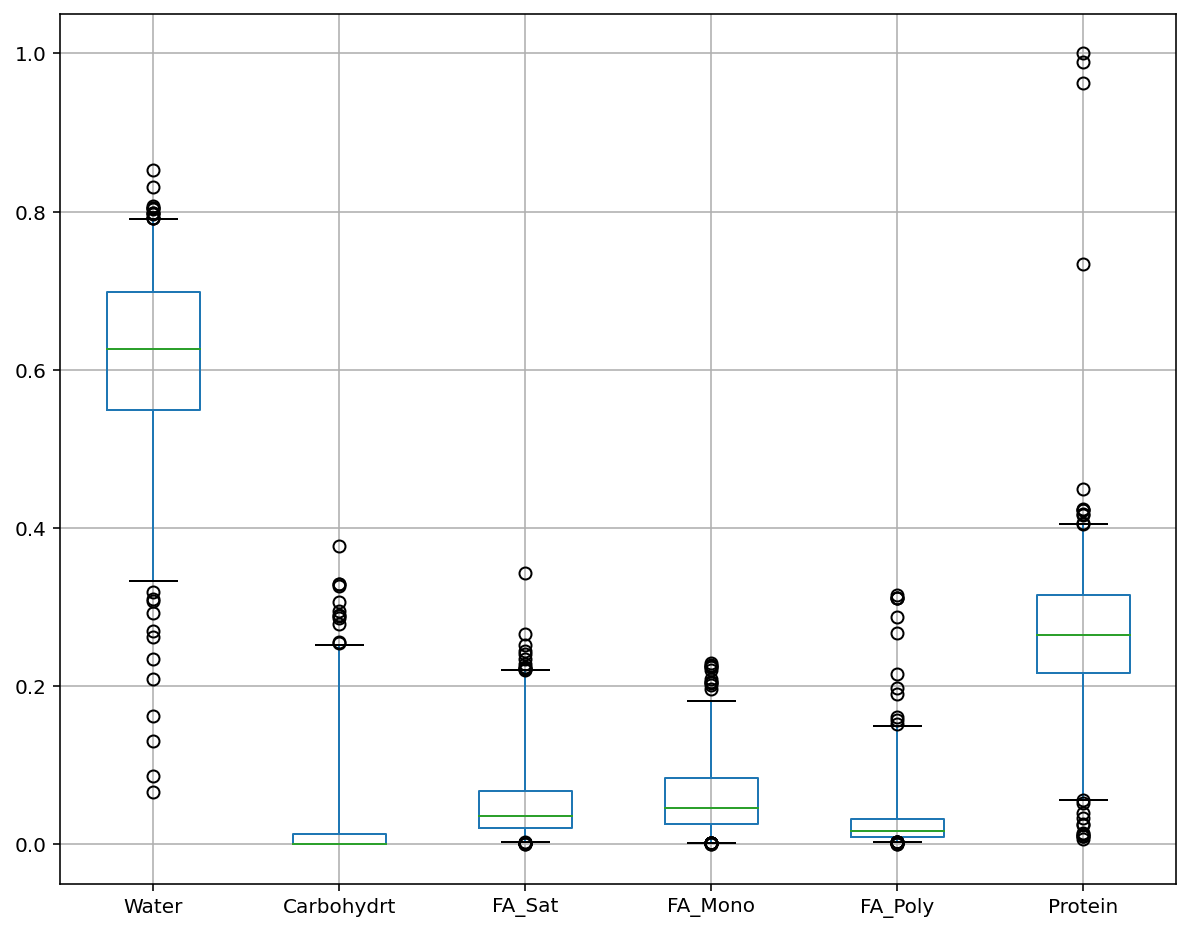

In [0]:
boxplot0ma = cluster_0ma.boxplot(column=['Water', 'Carbohydrt', 'FA_Sat', 'FA_Mono', 'FA_Poly', 'Protein'], figsize=(10,8),
                   whis=[2,98], return_type='axes')


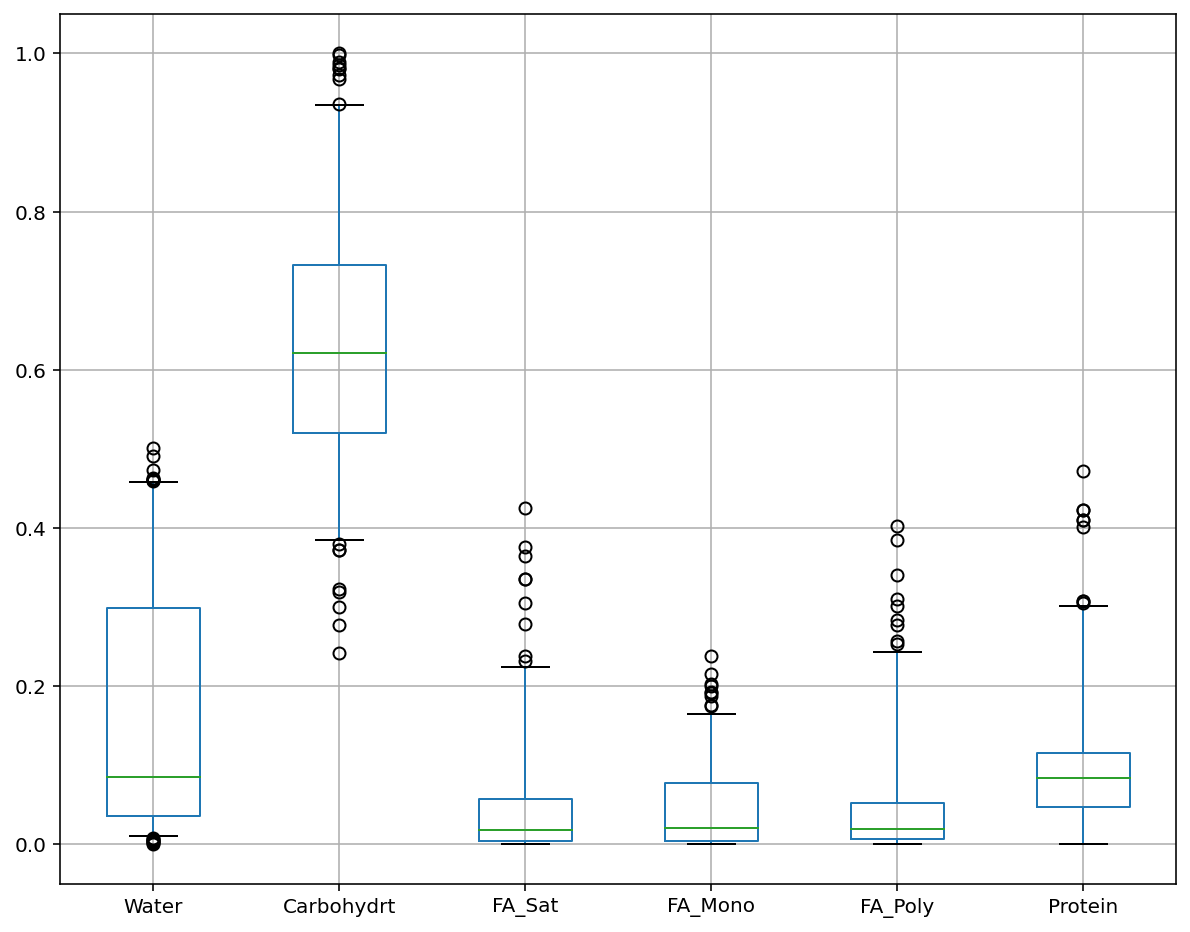

In [0]:
boxplot1ma = cluster_1ma.boxplot(column=['Water', 'Carbohydrt', 'FA_Sat', 'FA_Mono', 'FA_Poly', 'Protein'], figsize=(10,8),
                   whis=[2,98], return_type='axes')


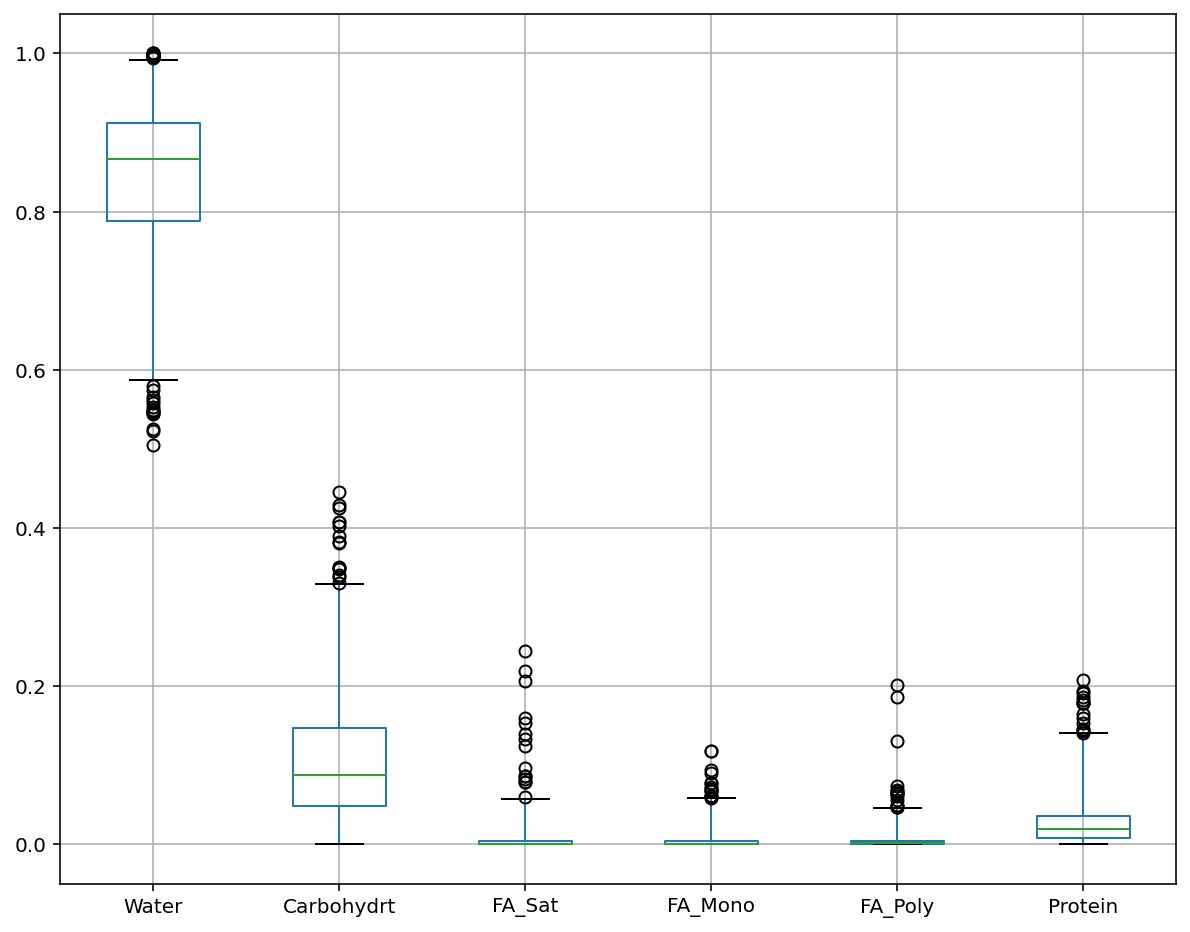

In [0]:
boxplot2ma = cluster_2ma.boxplot(column=['Water', 'Carbohydrt', 'FA_Sat', 'FA_Mono', 'FA_Poly', 'Protein'], figsize=(10,8),
                   whis=[2,98], return_type='axes')


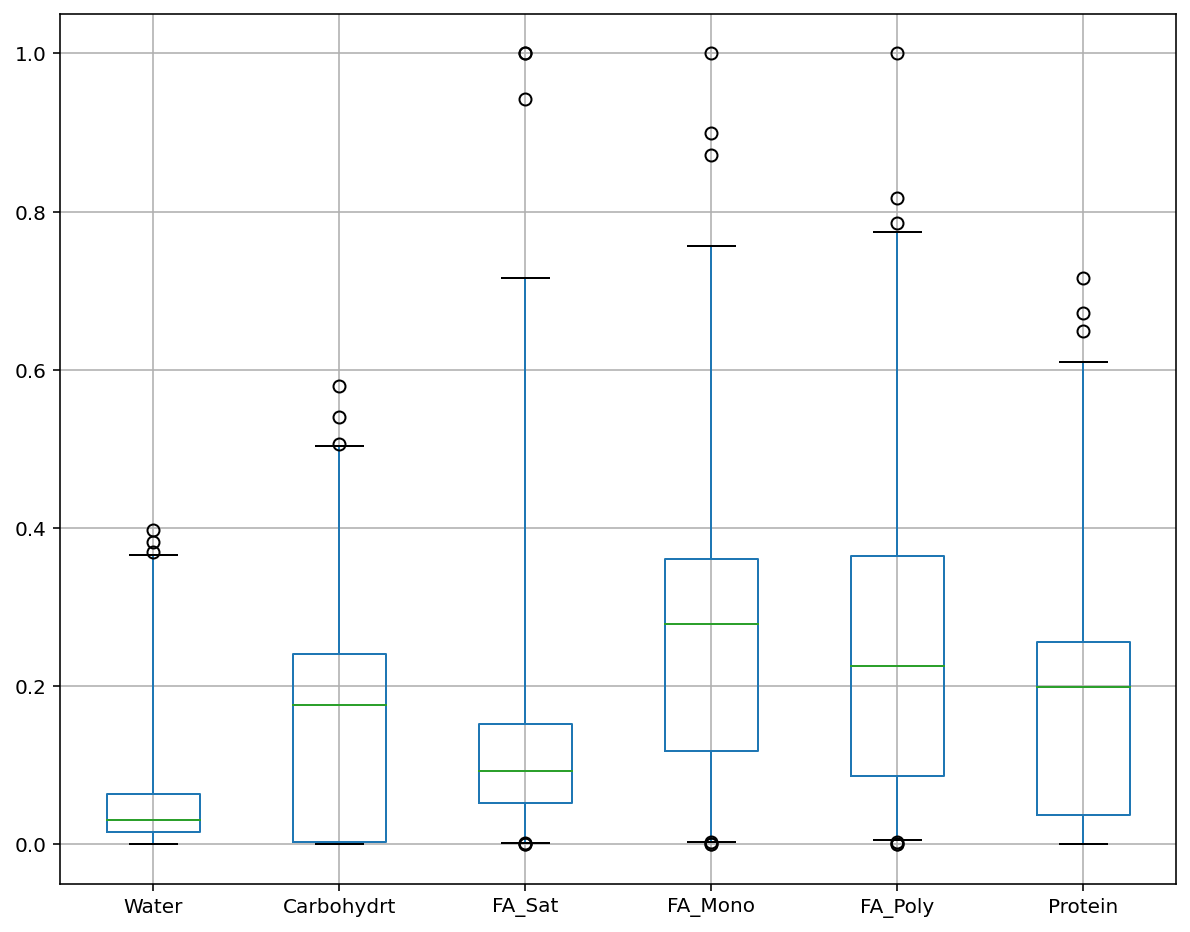

In [0]:
boxplot3ma = cluster_3ma.boxplot(column=['Water', 'Carbohydrt', 'FA_Sat', 'FA_Mono', 'FA_Poly', 'Protein'], figsize=(10,8),
                   whis=[2,98], return_type='axes')

In [0]:
carbo = alt.Chart(macro_distribution).mark_boxplot().encode(
    x='Carbohydrt:Q',
    y='Cluster:N',
    color='Outlier:N'
)
water = alt.Chart(macro_distribution).mark_boxplot().encode(
    x='Water:Q',
    y='Cluster:N',
    color='Outlier:N'
)
satfat = alt.Chart(macro_distribution).mark_boxplot().encode(
    x='FA_Sat:Q',
    y='Cluster:N',
    color='Outlier:N'
)
monofat = alt.Chart(macro_distribution).mark_boxplot().encode(
    x='FA_Mono:Q',
    y='Cluster:N',
    color='Outlier:N'
)
polyfat = alt.Chart(macro_distribution).mark_boxplot().encode(
    x='FA_Poly:Q',
    y='Cluster:N',
    color='Outlier:N'
)
protein = alt.Chart(macro_distribution).mark_boxplot().encode(
    x='Protein:Q',
    y='Cluster:N',
    color='Outlier:N'
)
carbo | water | satfat | monofat | polyfat | protein

alt.HConcatChart(...)

In [0]:
alt.Chart(outliers_processed).mark_boxplot().encode(
    x='cluster:N',
    y='macros:Q',
    color='outlier:N'
)

alt.Chart(...)

##### Vitamins BoxPlots

In [0]:
vitamin_distribution = processed[[col for col in df if col.startswith('Vit')]]
vitamin_distribution['Cluster'] = tsne_df['Cluster']
vitamin_distribution['Outlier'] = outliers_processed['outlier']
vitamin_distribution

In [0]:
cluster_0v = vitamin_distribution[vitamin_distribution['Cluster']==0]
cluster_1v = vitamin_distribution[vitamin_distribution['Cluster']==1]
cluster_2v = vitamin_distribution[vitamin_distribution['Cluster']==2]
cluster_3v = vitamin_distribution[vitamin_distribution['Cluster']==3]

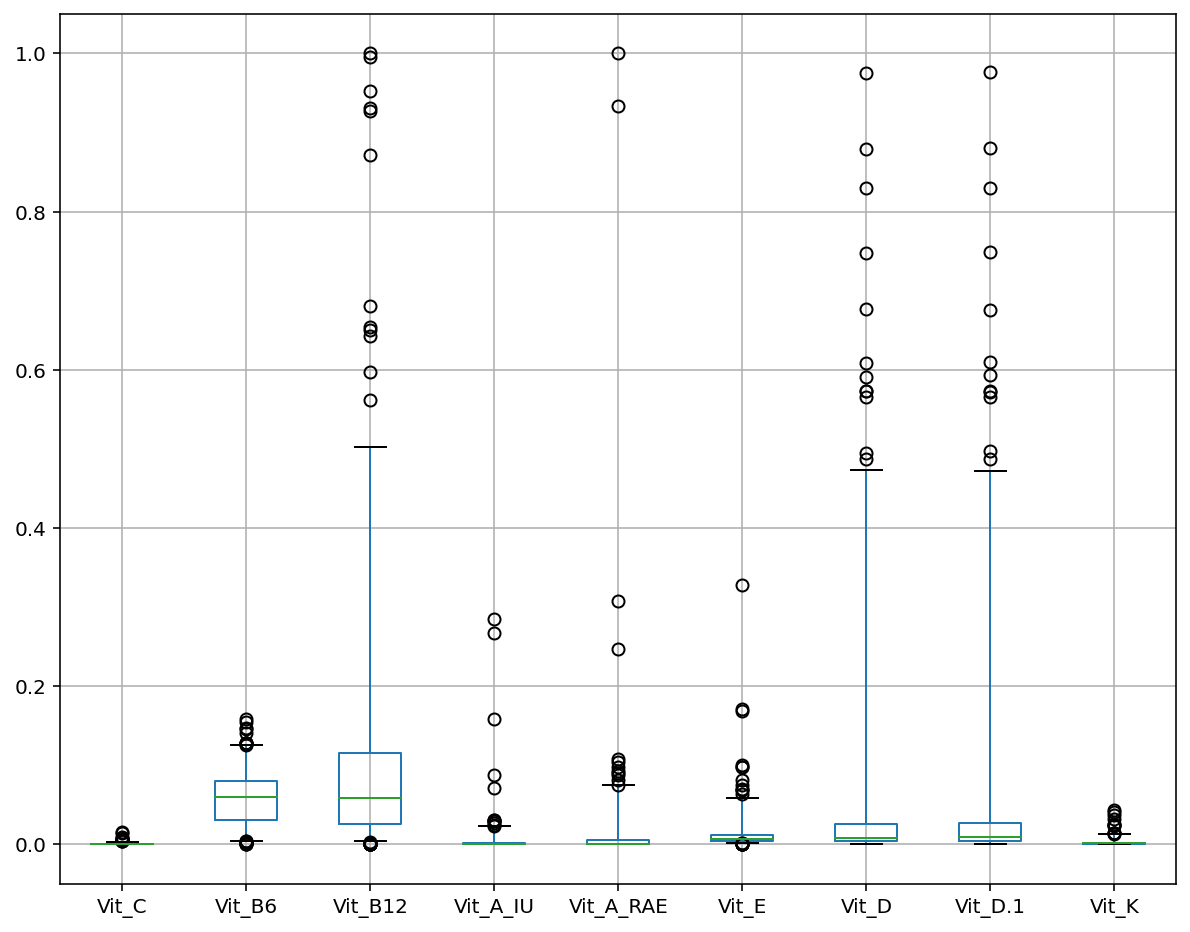

In [0]:
boxplot0v = cluster_0v.boxplot(column=[col for col in df if col.startswith('Vit')], figsize=(10,8),
                   whis=[2,98], return_type='axes')

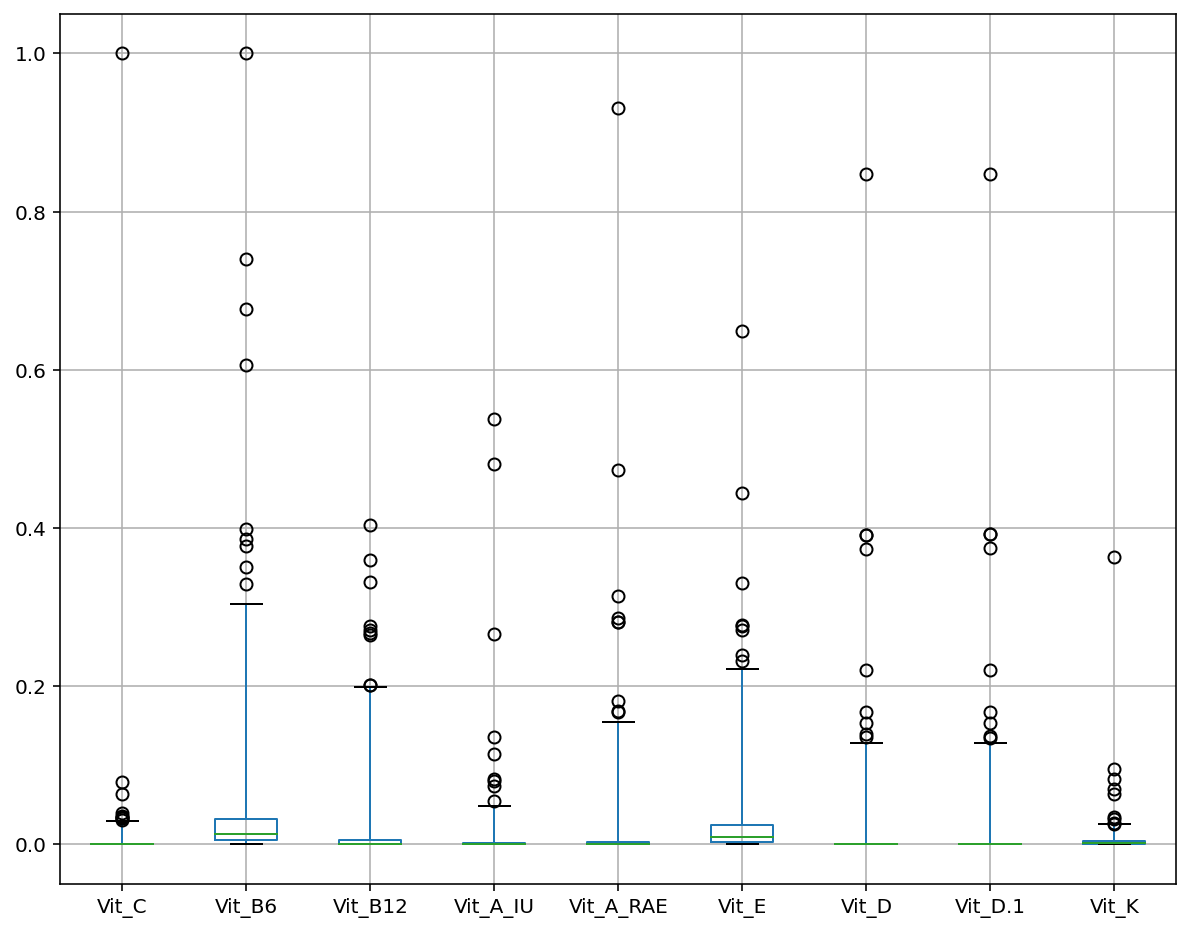

In [0]:
boxplot1v = cluster_1v.boxplot(column=[col for col in df if col.startswith('Vit')], figsize=(10,8),
                   whis=[2,98], return_type='axes')

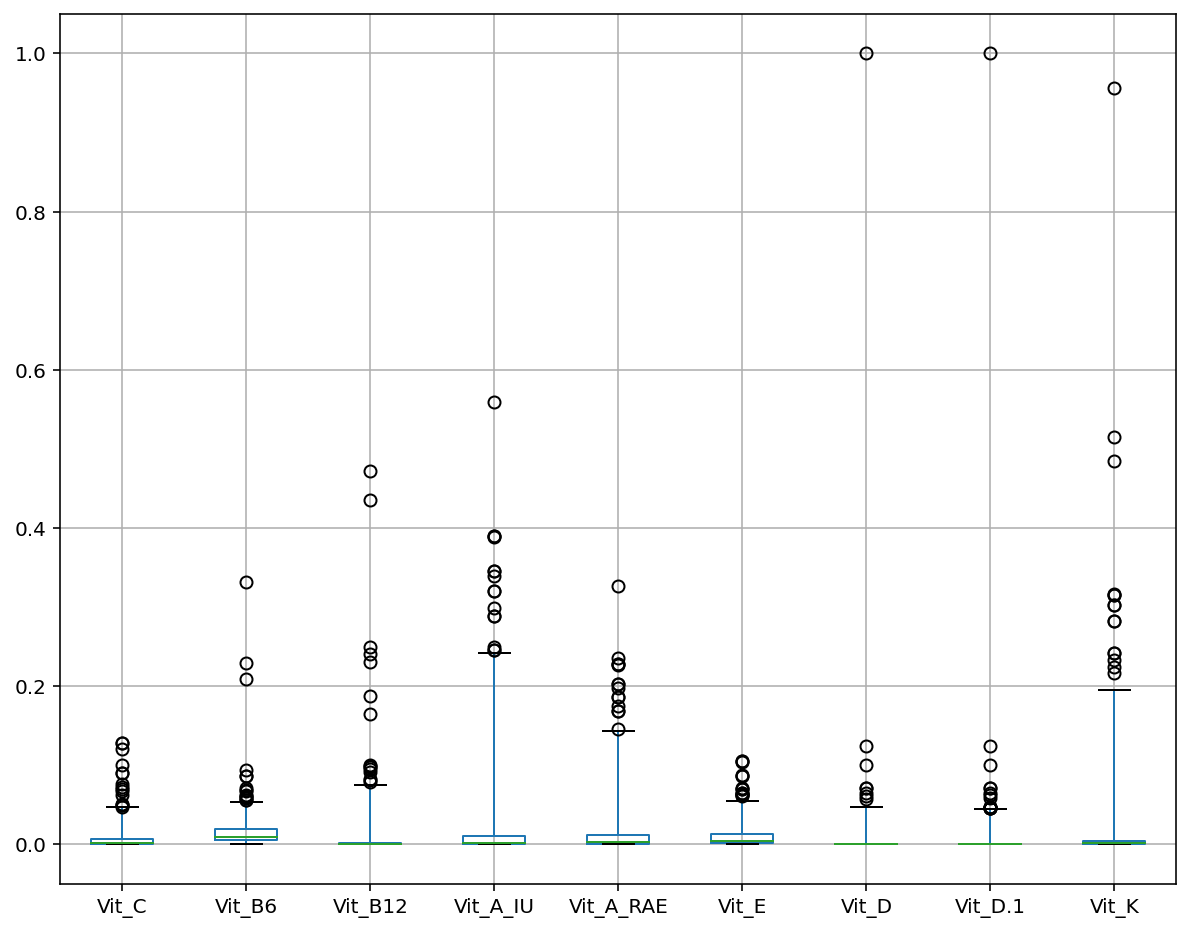

In [0]:
boxplot2v = cluster_2v.boxplot(column=[col for col in df if col.startswith('Vit')], figsize=(10,8),
                   whis=[2,98], return_type='axes')

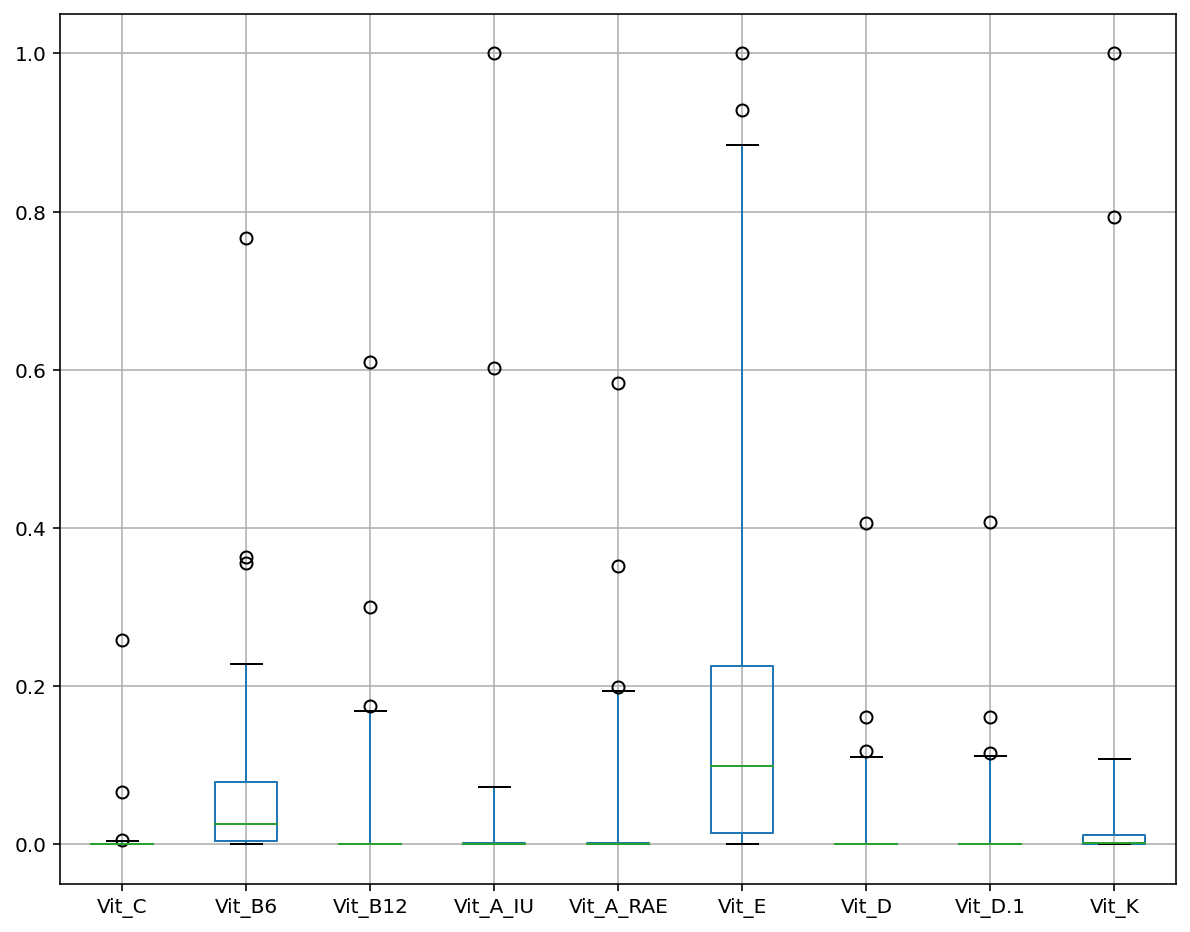

In [0]:
boxplot3v = cluster_3v.boxplot(column=[col for col in df if col.startswith('Vit')], figsize=(10,8),
                   whis=[2,98], return_type='axes')

##### Minerals BoxPlots

In [0]:
minerals_distribution = processed[['Sodium', 'Potassium', 'Manganese', 'Zinc', 'Calcium', 'Iron', 'Phosphorus', 'Magnesium', 'Copper']]
minerals_distribution['Cluster'] = tsne_df['Cluster']
minerals_distribution['Outlier'] = outliers_processed['outlier']
minerals_distribution

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Sodium  Potassium  Manganese  ...    Copper  Cluster  Outlier
0     0.018422   0.001455   0.000000  ...  0.000000        3        0
1     0.021338   0.001576   0.000067  ...  0.002623        3        0
2     0.000052   0.000303   0.000000  ...  0.000164        3        0
3     0.035993   0.015515   0.000150  ...  0.006557        0        0
4     0.014449   0.008242   0.000200  ...  0.003934        0        0
...        ...        ...        ...  ...       ...      ...      ...
1831  0.018345   0.000545   0.001464  ...  0.001639        0        0
1832  0.000000   0.000000   0.000000  ...  0.000000        3        0
1833  0.073224   0.077515   0.011692  ...  0.137377        1        0
1834  0.085815   0.034545   0.014752  ...  0.140000        1        0
1835  0.109655   0.001818   0.000682  ...  0.006230        1        0

[1836 rows x 11 columns]

In [0]:
cluster_0min = minerals_distribution[minerals_distribution['Cluster']==0]
cluster_1min = minerals_distribution[minerals_distribution['Cluster']==1]
cluster_2min = minerals_distribution[minerals_distribution['Cluster']==2]
cluster_3min = minerals_distribution[minerals_distribution['Cluster']==3]

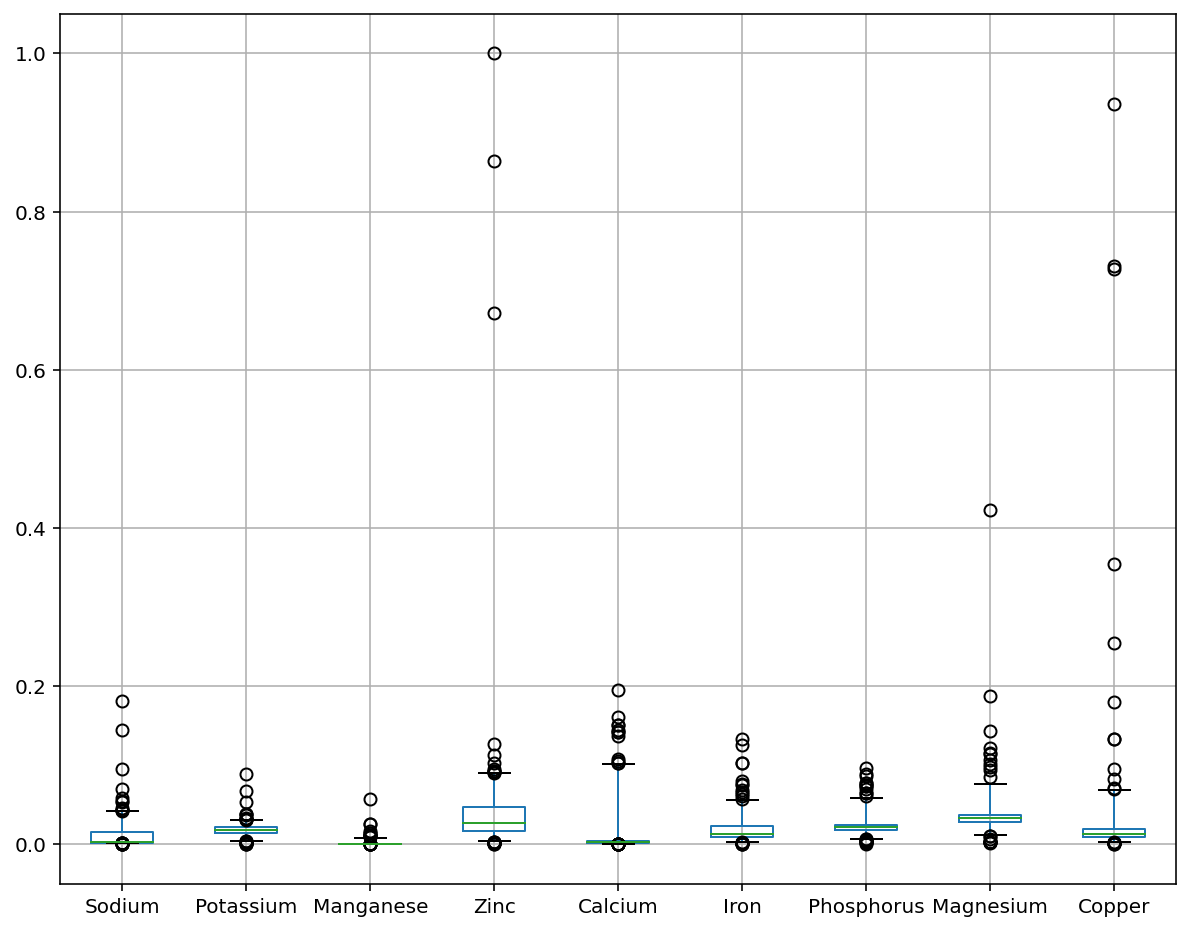

In [0]:
boxplot0min = cluster_0min.boxplot(column=['Sodium', 'Potassium', 'Manganese', 'Zinc', 'Calcium', 'Iron', 'Phosphorus', 'Magnesium', 'Copper'], figsize=(10,8),
                   whis=[2,98], return_type='axes')

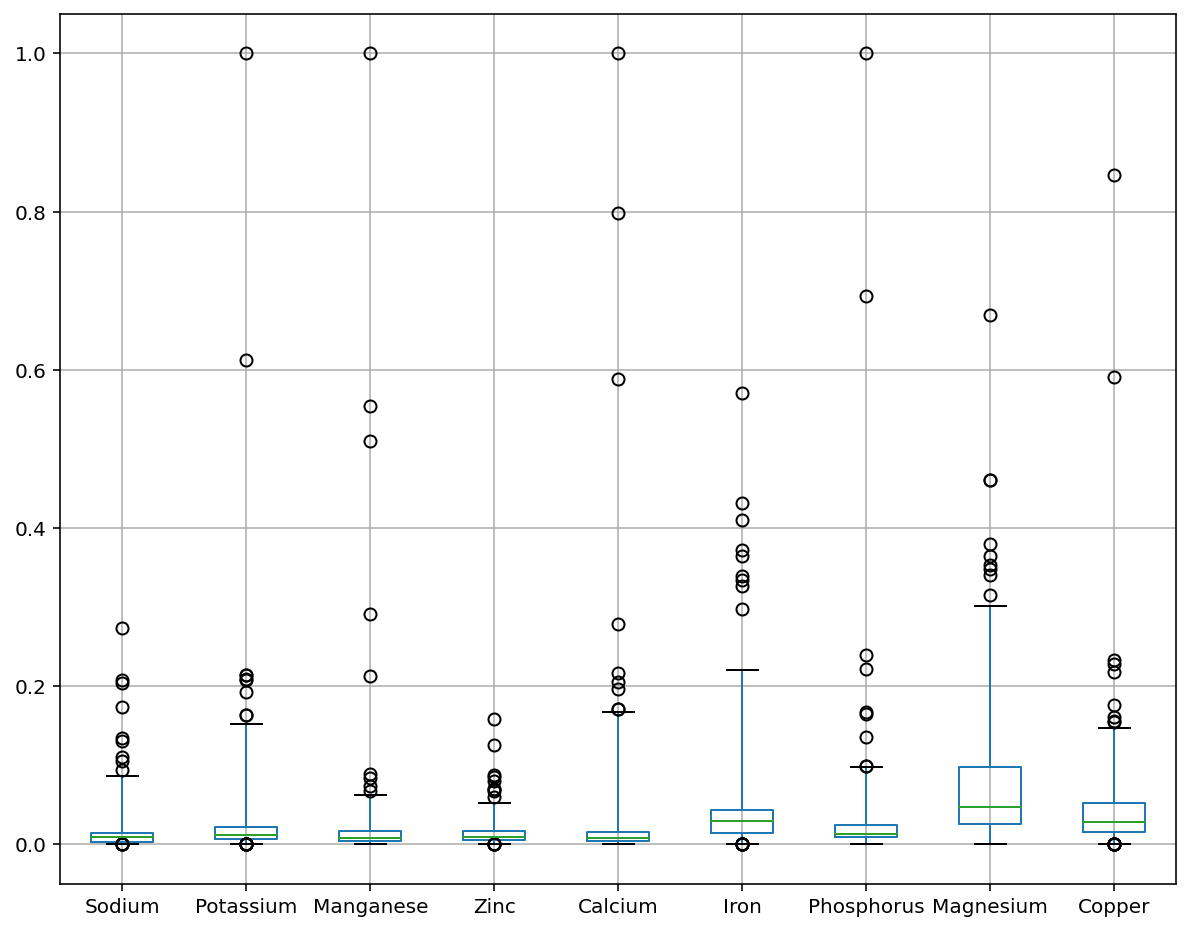

In [0]:
boxplot1min = cluster_1min.boxplot(column=['Sodium', 'Potassium', 'Manganese', 'Zinc', 'Calcium', 'Iron', 'Phosphorus', 'Magnesium', 'Copper'], figsize=(10,8),
                   whis=[2,98], return_type='axes')

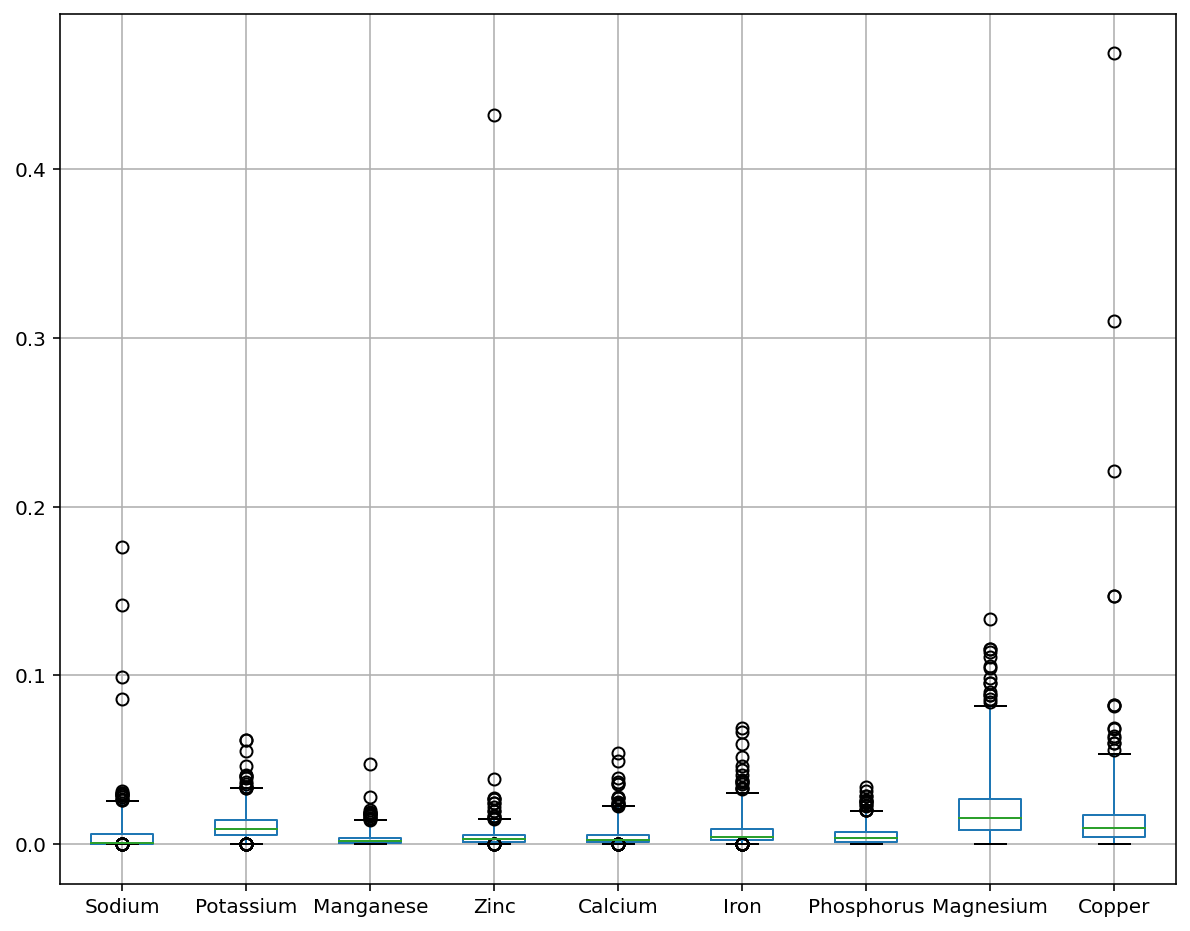

In [0]:
boxplot2min = cluster_2min.boxplot(column=['Sodium', 'Potassium', 'Manganese', 'Zinc', 'Calcium', 'Iron', 'Phosphorus', 'Magnesium', 'Copper'], figsize=(10,8),
                   whis=[2,98], return_type='axes')

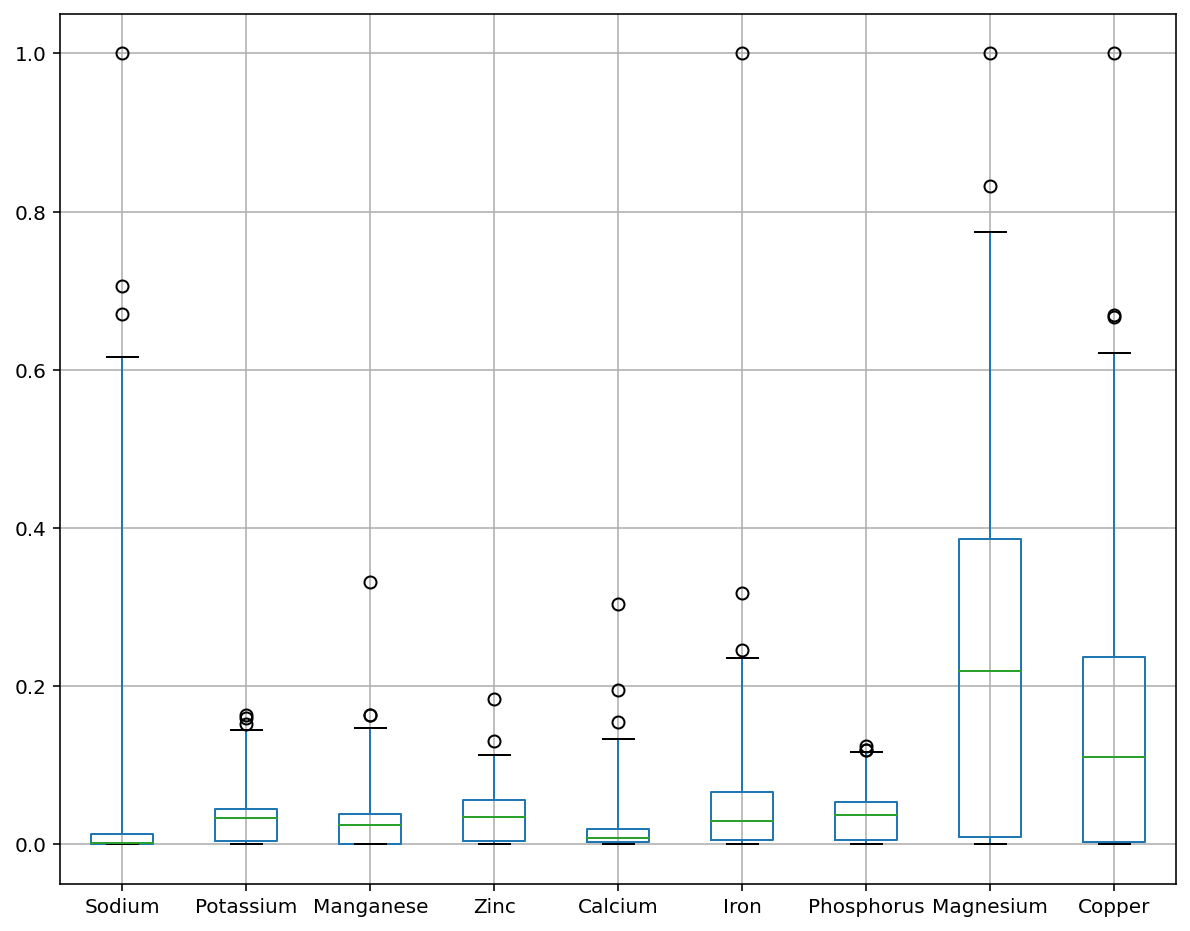

In [0]:
boxplot3min = cluster_3min.boxplot(column=['Sodium', 'Potassium', 'Manganese', 'Zinc', 'Calcium', 'Iron', 'Phosphorus', 'Magnesium', 'Copper'], figsize=(10,8),
                   whis=[2,98], return_type='axes')

In [0]:
alt.Chart(outliers_processed).mark_boxplot().encode(
    y='cluster:N',
    x='vitamins:Q',
    color='outlier:N'
)

alt.Chart(...)

In [0]:
cluster1 = processed_cluster[processed_cluster['cluster']==1]

## Set 2

### Macros

In [0]:
macro_features = ['Carbohydrt', 'FA_Sat', 'FA_Mono', 'FA_Poly', 'Protein','Water','Fiber_TD','Sugar_Tot']

''' Here we simply convert non-numeric values into 0 '''
# this step change strings into NaN
processedMacro = reduced_df[macro_features].apply(pd.to_numeric, errors="coerce")

# then we change NaN to 0
processedMacro = processedMacro.replace(np.nan,0)
processedMacro

Carbohydrt  FA_Sat  FA_Mono  FA_Poly  Protein  Water  Fiber_TD  Sugar_Tot
0           0.06  51.368   21.021    3.043     0.85  15.87       0.0       0.06
1           0.06  50.489   23.426    3.012     0.85  15.87       0.0       0.06
2           0.00  61.924   28.732    3.694     0.28   0.24       0.0       0.00
3           2.34  18.669    7.778    0.800    21.40  42.41       0.0       0.50
4           2.79  18.764    8.598    0.784    23.24  41.11       0.0       0.51
...          ...     ...      ...      ...      ...    ...       ...        ...
1831       23.90   5.000    9.000   18.000     0.90  39.90       0.0       6.40
1832        0.00  14.367   48.033   33.033     0.00   0.00       0.0       0.00
1833       78.20   0.984    1.154    0.131     5.30   4.20       6.1       0.70
1834       74.42   1.578    1.150    0.130    10.08   6.80      10.1       0.70
1835       84.66   0.099    0.116    0.433     0.81   6.84       0.8       0.90

[1836 rows x 8 columns]

In [0]:
for column in processedMacro:
  processedMacro[column] = processedMacro[column]/processedMacro[column].max()

processedMacro

Carbohydrt    FA_Sat   FA_Mono  ...     Water  Fiber_TD  Sugar_Tot
0       0.000600  0.593829  0.251180  ...  0.158859  0.000000   0.000601
1       0.000600  0.583668  0.279917  ...  0.158859  0.000000   0.000601
2       0.000000  0.715860  0.343319  ...  0.002402  0.000000   0.000000
3       0.023405  0.215819  0.092939  ...  0.424525  0.000000   0.005010
4       0.027906  0.216917  0.102738  ...  0.411512  0.000000   0.005110
...          ...       ...       ...  ...       ...       ...        ...
1831    0.239048  0.057801  0.107541  ...  0.399399  0.000000   0.064128
1832    0.000000  0.166087  0.573946  ...  0.000000  0.000000   0.000000
1833    0.782156  0.011375  0.013789  ...  0.042042  0.114878   0.007014
1834    0.744349  0.018242  0.013741  ...  0.068068  0.190207   0.007014
1835    0.846769  0.001144  0.001386  ...  0.068468  0.015066   0.009018

[1836 rows x 8 columns]

#### K-Means -> TSNE

([<matplotlib.axis.XTick at 0x7ff5bb83eb00>,
 <a list of 14 Text major ticklabel objects>)

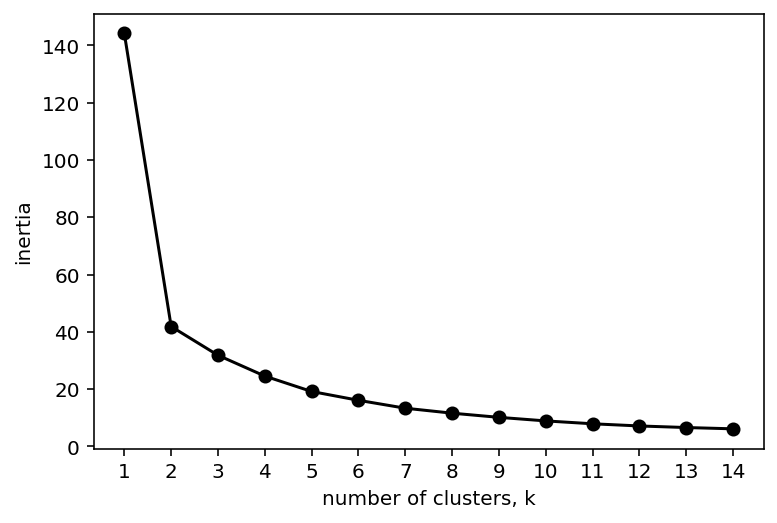

In [0]:
#@@@@@
ks = range(1, 15)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(processedMacro.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)

In [0]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)

In [0]:
kmeans.fit(processedMacro)
df_kmeans = pd.concat([reduced_df.reset_index(drop = True), pd.DataFrame(processedMacro)], axis = 1)
df_kmeans.columns.values[-3:] = ['Component 1', 'Compenent 2', 'Component 3']
df_kmeans['K-Means'] = kmeans.labels_
df_kmeans

Unnamed: 0  NDB_No  FdGrp_CD  ... Compenent 2 Component 3  K-Means
0              1    1001       100  ...    0.000000    0.000601        0
1              2    1002       100  ...    0.000000    0.000601        0
2              3    1003       100  ...    0.000000    0.000000        0
3              4    1004       100  ...    0.000000    0.005010        0
4              5    1005       100  ...    0.000000    0.005110        0
...          ...     ...       ...  ...         ...         ...      ...
1831        8175   43599       400  ...    0.000000    0.064128        0
1832        8176   44005       400  ...    0.000000    0.000000        0
1833        8180   44061      1900  ...    0.114878    0.007014        1
1834        8185   44258      1900  ...    0.190207    0.007014        1
1835        8187   44260      1900  ...    0.015066    0.009018        1

[1836 rows x 65 columns]

##### T-SNE

In [0]:
''' prepare the features for be analyszed '''
X = processedMacro[macro_features].values
result_tsne = TSNE(n_components=2,perplexity=50).fit_transform(X)

In [0]:
macro_tsne_df = pd.DataFrame(data=result_tsne, columns=['x','y'])

alt.Chart(macro_tsne_df).mark_point().encode(
    x='x:Q',
    y='y:Q',
)

alt.Chart(...)

In [0]:
macro_tsne_df['Cluster'] = df_kmeans['K-Means']
macro_tsne_df['Food_Group'] = reduced_df['FdGrp_Desc']
macro_tsne_df['Food_Description'] = df['Shrt_Desc']
macro_tsne_df['ID'] = df["NDB_No"]

In [0]:
tsne1 = alt.Chart(macro_tsne_df).mark_circle().encode(
    x='x:Q',
    y='y:Q',
    color='Cluster:N',
    tooltip=['Cluster', 'Food_Group', 'Food_Description']
)
tsne1

alt.Chart(...)

In [0]:
tsne2 = alt.Chart(macro_tsne_df).mark_circle().encode(
    x='x:Q',
    y='y:Q',
    color='Food_Group:N',
    tooltip=['Cluster', 'Food_Group', 'Food_Description']
)
tsne2

alt.Chart(...)

In [0]:
tsne1 | tsne2

alt.HConcatChart(...)

In [0]:
test = macro_tsne_df[['Cluster', 'Food_Group']]
check = test.groupby('Food_Group')['Cluster'].value_counts().reset_index(name='Counts')
check

Food_Group  Cluster  Counts
0                       Baby Foods        2      45
1                       Baby Foods        1       2
2                       Baby Foods        0       1
3                   Baked Products        1     208
4                   Baked Products        0       9
5                   Baked Products        2       6
6                        Beverages        2      70
7                        Beverages        1      14
8                        Beverages        0       1
9                Breakfast Cereals        1      17
10               Breakfast Cereals        2       8
11         Cereal Grains and Pasta        2       3
12         Cereal Grains and Pasta        1       2
13          Dairy and Egg Products        2      58
14          Dairy and Egg Products        0      56
15          Dairy and Egg Products        1      13
16                      Fast Foods        0      16
17                      Fast Foods        1       2
18                   Fats and Oils        0      24
19                   Fats and Oils        2      15
20                   Fats and Oils        1       4
21  Finfish and Shellfish Products        0      60
22  Finfish and Shellfish Products        2      34
23     Legumes and Legume Products        1      26
24     Legumes and Legume Products        2      21
25     Legumes and Legume Products        0       6
26                           Meals        0       7
27                           Meals        2       4
28                            Meat        0     384
29                            Meat        2       7
30           Nut and Seed Products        1      45
31           Nut and Seed Products        0       2
32           Nut and Seed Products        2       2
33                         Produce        2     356
34                         Produce        1      16
35                         Produce        0       2
36     Sausages and Luncheon Meats        0      37
37     Sausages and Luncheon Meats        2       2
38                          Snacks        1      34
39                          Snacks        0       2
40      Soups, Sauces, and Gravies        2      78
41      Soups, Sauces, and Gravies        1      11
42                Spices and Herbs        1      13
43                Spices and Herbs        2       6
44                Spices and Herbs        0       1
45                          Sweets        1      91
46                          Sweets        2      13
47                          Sweets        0       2

In [0]:
alt.Chart(check).mark_bar().encode(
    y=alt.X('Food_Group', sort='-y'),
    x=alt.Y('Counts', stack='normalize'),
    color='Cluster:N'
)

alt.Chart(...)

#### Non Dominating Clusters: Dairy and Egg Products, Legumes and Legume Products, Fats and Oils

In [0]:
macro_cluster = processedMacro.copy()
macro_cluster['cluster'] = macro_tsne_df['Cluster']
macro_cluster['group'] = df['FdGrp_Desc']
macro_cluster['description'] = df['Shrt_Desc']
macro_cluster['ID'] = df['NDB_No']

In [0]:
mac_dairy = macro_cluster[macro_cluster['group'] == 'Dairy and Egg Products']
mac_legume = macro_cluster[macro_cluster['group'] == 'Legumes and Legume Products']
mac_fat = macro_cluster[macro_cluster['group'] == 'Fats and Oils']

In [0]:
mac_dairy

Carbohydrt  ...     ID
0       0.000600  ...   1001
1       0.000600  ...   1002
2       0.000000  ...   1003
3       0.023405  ...   1004
4       0.027906  ...   1005
...          ...  ...    ...
122     0.037007  ...   1253
123     0.085617  ...   1254
124     0.047209  ...   1258
1825    0.081316  ...  43274
1829    0.198840  ...  43528

[127 rows x 12 columns]

In [0]:
px.parallel_coordinates(mac_dairy, color='cluster', dimensions=['cluster','group','Carbohydrt', 'FA_Sat', 'FA_Mono', 'FA_Poly', 'Protein','Water','Fiber_TD','Sugar_Tot'], 
                         color_continuous_scale=[(0.00, "blue"),   (0.25, "blue"),
                                                (0.25, "goldenrod"), (0.5, "goldenrod"),
                                                (0.5, "red"),  (.75, "red"),
                                                (0.75,"green"),(1,"green")],)

In [0]:
px.parallel_coordinates(mac_legume, color='cluster', dimensions=['cluster','group','Carbohydrt', 'FA_Sat', 'FA_Mono', 'FA_Poly', 'Protein','Water','Fiber_TD','Sugar_Tot'], 
                         color_continuous_scale=[(0.00, "blue"),   (0.25, "blue"),
                                                (0.25, "goldenrod"), (0.5, "goldenrod"),
                                                (0.5, "red"),  (.75, "red"),
                                                (0.75,"green"),(1,"green")],)

In [0]:
px.parallel_coordinates(mac_fat, color='cluster', dimensions=['cluster','group','Carbohydrt', 'FA_Sat', 'FA_Mono', 'FA_Poly', 'Protein','Water','Fiber_TD','Sugar_Tot'], 
                         color_continuous_scale=[(0.00, "blue"),   (0.25, "blue"),
                                                (0.25, "goldenrod"), (0.5, "goldenrod"),
                                                (0.5, "red"),  (.75, "red"),
                                                (0.75,"green"),(1,"green")],)

In [0]:
mac_dairy.columns


Index(['Carbohydrt', 'FA_Sat', 'FA_Mono', 'FA_Poly', 'Protein', 'Water',
       'Fiber_TD', 'Sugar_Tot', 'cluster', 'group', 'description', 'ID'],
      dtype='object')

In [0]:
mac_dairy_list=[]

mac_dairy_list.extend(mac_dairy[(mac_dairy['cluster']==2) & (mac_dairy['Fiber_TD']>.012)]['ID'].tolist())
mac_dairy_list.extend(mac_dairy[(mac_dairy['cluster']==1) & (mac_dairy['Carbohydrt']>.7)]['ID'].tolist())
mac_dairy_list.extend(mac_dairy[(mac_dairy['cluster']==0) & (mac_dairy['FA_Sat']>.5)]['ID'].tolist())
mac_dairy_list.extend(mac_dairy[(mac_dairy['cluster']==0) & (mac_dairy['FA_Poly']>.1)]['ID'].tolist())
mac_dairy_list.extend(mac_dairy[(mac_dairy['cluster']==0) & (mac_dairy['Protein']>.9)]['ID'].tolist())
print(mac_dairy_list)

[1102, 1103, 1105, 1113, 1115, 1001, 1002, 1003, 1145, 1133, 1137, 1136, 1258]


In [0]:
mac_legume_list=[]  #mac_legume
mac_legume_list.extend(mac_legume[(mac_legume['cluster']==1) & (mac_legume['Carbohydrt']>.8)]['ID'].tolist())
mac_legume_list.extend(mac_legume[(mac_legume['cluster']==1) & (mac_legume['Fiber_TD']>.7)]['ID'].tolist())
mac_legume_list.extend(mac_legume[(mac_legume['cluster']==1) & (mac_legume['FA_Sat']>.11)]['ID'].tolist())
mac_legume_list.extend(mac_legume[(mac_legume['cluster']==0) & (mac_legume['FA_Sat']==0)]['ID'].tolist())
print(mac_legume_list)

[16055, 16055, 16098, 16167, 16398]


In [0]:
mac_fat_list=[]  #mac_fat
mac_fat_list.extend(mac_fat[(mac_fat['cluster']==1) & (mac_fat['Carbohydrt']==0)]['ID'].tolist())
print(mac_fat_list)

[4044, 4531]


In [0]:
mac_outliers = mac_dairy_list  + mac_legume_list 
mac_out = macro_cluster[macro_cluster['ID'].isin(mac_outliers)]
mac_out[['cluster', 'group', 'description']]

cluster  ...                                        description
0           0  ...                                   BUTTER,WITH SALT
1           0  ...                           BUTTER,WHIPPED,WITH SALT
2           0  ...                               BUTTER OIL,ANHYDROUS
70          2  ...  MILK,CHOC,FLUID,COMM,WHL,W/ ADDED VIT A & VITA...
71          2  ...                       MILK,CHOC,FLUID,COMM,RED FAT
73          2  ...                   MILK,CHOC BEV,HOT COCOA,HOMEMADE
78          1  ...                                    WHEY,ACID,DRIED
79          1  ...                                   WHEY,SWEET,DRIED
92          0  ...                                    EGG,WHOLE,DRIED
93          0  ...         EGG,WHITE,DRIED,PDR,STABILIZED,GLUCOSE RED
94          0  ...                                     EGG,YOLK,DRIED
96          0  ...                                BUTTER,WITHOUT SALT
124         0  ...             EGG,WHITE,DRIED,STABILIZED,GLUCOSE RED
1264        1  ...                                        CAROB FLOUR
1281        1  ...                 PEANUT BUTTER,SMOOTH STYLE,W/ SALT
1299        1  ...                      USDA CMDTY,PNUT BUTTER,SMOOTH
1304        1  ...                 PEANUT BUTTER,SMOOTH STYLE,WO/SALT

[17 rows x 3 columns]

#### Minorities of Dominating Clusters

In [0]:
processed_cluster['group'].value_counts()

In [0]:
meat = processed_cluster[processed_cluster['group'] == 'Meat']
babyfood = processed_cluster[processed_cluster['group'] == 'Baby Foods']
sweets = processed_cluster[processed_cluster['group'] == 'Sweets']
beverages = processed_cluster[processed_cluster['group'] == 'Beverages']
nut= processed_cluster[processed_cluster['group'] == 'Nut and Seed Products']
bakedproducts= processed_cluster[processed_cluster['group'] == 'Baked Products']
produce= processed_cluster[processed_cluster['group'] == 'Produce']

Meats Consistent outliers:
sugar> 0.0.35

In [0]:
px.parallel_coordinates(meat, color='cluster', dimensions=['cluster','group','Carbohydrt', 'FA_Sat', 'FA_Mono', 'FA_Poly', 'Protein','Water','Fiber_TD','Sugar_Tot','Lipid_Tot'], 
                         color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)

In [0]:
MeatIDList=[]
MeatIDList.extend(meat[meat['Sugar_Tot']>0.03]['ID'].tolist())
MeatOutliers = meat[meat.ID.isin(MeatIDList)]
MeatOutliers


PORK
id= 10870,10871,10872,10905,10921,10922



babyfood outliers

In [0]:
px.parallel_coordinates(babyfood, color='cluster', dimensions=['cluster','group','Carbohydrt', 'FA_Sat', 'FA_Mono', 'FA_Poly', 'Protein','Water','Fiber_TD','Sugar_Tot','Lipid_Tot'], 
                         color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)

In [0]:
MeatIDList=[]
MeatIDList.extend(babyfood[babyfood['FA_Sat']>0.045]['ID'].tolist())
MeatIDList.extend(babyfood[babyfood['Fiber_TD']>0.14]['ID'].tolist())
MeatIDList.extend(babyfood[babyfood['Sugar_Tot']>0.2]['ID'].tolist())
MeatOutliers = babyfood[babyfood.ID.isin(MeatIDList)]
MeatOutliers

sweets

In [0]:
px.parallel_coordinates(sweets, color='cluster', dimensions=['cluster','group','Carbohydrt', 'FA_Sat', 'FA_Mono', 'FA_Poly', 'Protein','Water','Fiber_TD','Sugar_Tot','Lipid_Tot'], 
                         color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)

In [0]:
MeatIDList=[]
MeatIDList.extend(sweets[sweets['Protein']>0.9]['ID'].tolist())
MeatOutliers = sweets[sweets.ID.isin(MeatIDList)]
MeatOutliers

GELATINS,DRY PDR,UNSWTND, ID 19177

beverages

In [0]:
px.parallel_coordinates(beverages, color='cluster', dimensions=['cluster','group','Carbohydrt', 'FA_Sat', 'FA_Mono', 'FA_Poly', 'Protein','Water','Fiber_TD','Sugar_Tot','Lipid_Tot'], 
                         color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)

In [0]:
MeatIDList=[]
MeatIDList.extend(beverages[beverages['Lipid_Tot']>0.12]['ID'].tolist())
MeatOutliers = beverages[beverages.ID.isin(MeatIDList)]
MeatOutliers

ALCOHOLIC BEV,LIQUEUR,COFFEE W/CRM,34 PROOF, ID 14415

nut

In [0]:
px.parallel_coordinates(nut, color='cluster', dimensions=['cluster','group','Carbohydrt', 'FA_Sat', 'FA_Mono', 'FA_Poly', 'Protein','Water','Fiber_TD','Sugar_Tot','Lipid_Tot'], 
                         color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)

In [0]:
MeatIDList=[]
MeatIDList.extend(nut[nut['Protein']>0.3]['ID'].tolist())
MeatIDList.extend(nut[nut['Water']>0.8]['ID'].tolist())
MeatOutliers = nut[nut.ID.isin(MeatIDList)]
MeatOutliers

baked

In [0]:
px.parallel_coordinates(bakedproducts, color='cluster', dimensions=['cluster','group','Carbohydrt', 'FA_Sat', 'FA_Mono', 'FA_Poly', 'Protein','Water','Fiber_TD','Sugar_Tot','Lipid_Tot'], 
                         color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)

In [0]:
MeatIDList=[]
MeatIDList.extend(bakedproducts[bakedproducts['Water']>0.5]['ID'].tolist())
MeatOutliers = bakedproducts[bakedproducts.ID.isin(MeatIDList)]
MeatOutliers

produyce


In [0]:
px.parallel_coordinates(produce, color='cluster', dimensions=['cluster','group','Carbohydrt', 'FA_Sat', 'FA_Mono', 'FA_Poly', 'Protein','Water','Fiber_TD','Sugar_Tot','Lipid_Tot'], 
                         color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)

In [0]:
MeatIDList=[]
MeatIDList.extend(produce[produce['FA_Poly']>0.12]['ID'].tolist())
MeatIDList.extend(produce[produce['Lipid_Tot']>0.13]['ID'].tolist())
MeatOutliers = produce[produce.ID.isin(MeatIDList)]
MeatOutliers

###Minerals

In [0]:
mineral_features = ['Calcium', 'Iron', 'Magnesium', 'Phosphorus', 'Potassium',
       'Sodium', 'Zinc', 'Copper', 'Manganese', 'Selenium']

''' Here we simply convert non-numeric values into 0 '''
# this step change strings into NaN
processedMins = reduced_df[mineral_features].apply(pd.to_numeric, errors="coerce")

# then we change NaN to 0
processedMins = processedMins.replace(np.nan,0)

In [0]:
for column in processedMins:
  processedMins[column] = processedMins[column]/processedMins[column].max()

#### K-Means -> TSNE

([<matplotlib.axis.XTick at 0x7ff5b46dd240>,
 <a list of 14 Text major ticklabel objects>)

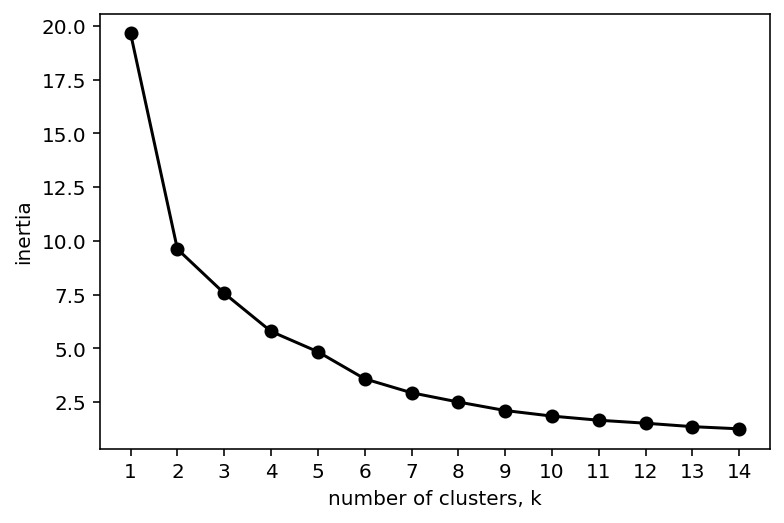

In [0]:
#@@@@@
ks = range(1, 15)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(processedMins.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)

In [0]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans.fit(processedMins)
df_kmeans = pd.concat([reduced_df.reset_index(drop = True), pd.DataFrame(processedMins)], axis = 1)
df_kmeans.columns.values[-3:] = ['Component 1', 'Compenent 2', 'Component 3']
df_kmeans['K-Means'] = kmeans.labels_

##### T-SNE

In [0]:
''' prepare the features for be analyszed '''
X = processedMins[mineral_features].values
result_tsne = TSNE(n_components=2,perplexity=50).fit_transform(X)

In [0]:
mins_tsne_df = pd.DataFrame(data=result_tsne, columns=['x','y'])

alt.Chart(mins_tsne_df).mark_point().encode(
    x='x:Q',
    y='y:Q',
)

alt.Chart(...)

In [0]:
mins_tsne_df['Cluster'] = df_kmeans['K-Means']
mins_tsne_df['Food_Group'] = reduced_df['FdGrp_Desc']
mins_tsne_df['Food_Description'] = df['Shrt_Desc']
mins_tsne_df['ID'] = df["NDB_No"]

In [0]:
tsne1 = alt.Chart(mins_tsne_df).mark_circle().encode(
    x='x:Q',
    y='y:Q',
    color='Cluster:N',
    tooltip=['Cluster', 'Food_Group', 'Food_Description']
)
tsne1

alt.Chart(...)

In [0]:
tsne2 = alt.Chart(mins_tsne_df).mark_circle().encode(
    x='x:Q',
    y='y:Q',
    color='Food_Group:N',
    tooltip=['Cluster', 'Food_Group', 'Food_Description']
)
tsne2

alt.Chart(...)

#### TSNE -> Kmeans

([<matplotlib.axis.XTick at 0x7ff5b4d97278>,
 <a list of 14 Text major ticklabel objects>)

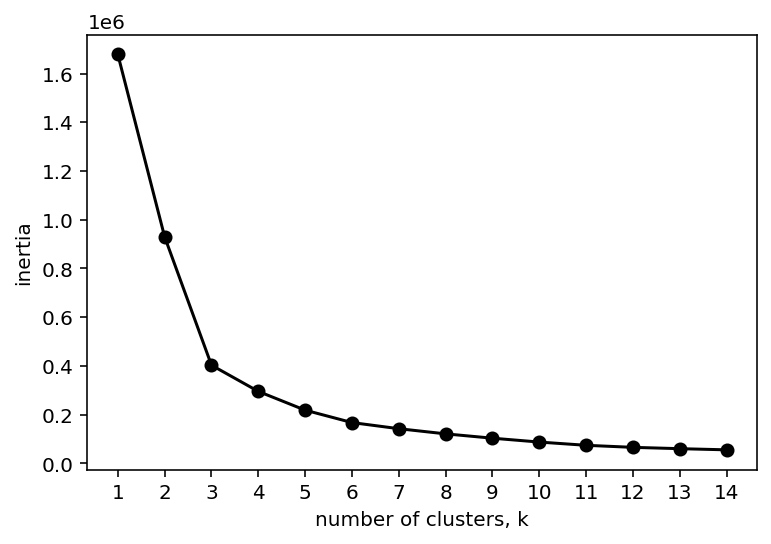

In [0]:
tsne_df_2 = pd.DataFrame(data=result_tsne, columns=['x','y'])
#@@@@@
ks = range(1, 15)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(tsne_df_2.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)

In [0]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans.fit(tsne_df_2)
df_kmeans2 = pd.concat([reduced_df.reset_index(drop = True), pd.DataFrame(tsne_df_2)], axis = 1)
df_kmeans2.columns.values[-3:] = ['Component 1', 'Compenent 2', 'Component 3']
tsne_df_2['K-Means'] = kmeans.labels_
tsne_df_2

x          y  K-Means
0     34.358906  -8.594917        2
1     33.802101  -7.789919        2
2     37.641037 -23.493101        2
3     -8.847571  -6.350637        0
4     -9.652557  -7.156291        0
...         ...        ...      ...
1831  33.708904  -8.625820        2
1832  37.798862 -25.355625        2
1833 -36.332031  -6.354434        0
1834 -30.611115   3.030869        0
1835  -1.472618   9.522878        0

[1836 rows x 3 columns]

In [0]:
tsne_df_2['Cluster'] = tsne_df_2['K-Means']
tsne_df_2['Food_Group'] = reduced_df['FdGrp_Desc']
tsne_df_2['Food_Description'] = df['Shrt_Desc']

In [0]:
tsne3 = alt.Chart(tsne_df_2).mark_circle().encode(
    x='x:Q',
    y='y:Q',
    color='K-Means:N',
    tooltip=['Cluster', 'Food_Group', 'Food_Description']
)

In [0]:
tsne3

alt.Chart(...)

In [0]:
test = tsne_df_2[['Cluster', 'Food_Group']]
check = test.groupby('Food_Group')['Cluster'].value_counts().reset_index(name='Counts')

In [0]:
alt.Chart(check).mark_bar().encode(
    y=alt.X('Food_Group', sort='-y'),
    x=alt.Y('Counts', stack='normalize'),
    color='Cluster:N'
)

alt.Chart(...)

In [0]:
check2 = test.groupby('Cluster')['Food_Group'].value_counts().reset_index(name='Counts')
alt.Chart(check2).mark_bar().encode(
    x=alt.X('Counts:Q', stack='normalize'),
    y=alt.Y('Cluster:O', sort='-y'),
    color='Food_Group:N',
    tooltip=['Food_Group']
)

alt.Chart(...)

In [0]:
mins_cluster = processedMins.copy()
mins_cluster['cluster'] = tsne_df_2['Cluster']
mins_cluster['group'] = df['FdGrp_Desc']
mins_cluster['description'] = df['Shrt_Desc']
mins_cluster['ID'] = df['NDB_No']
mins_cluster = mins_cluster[['ID','description','cluster','group','Calcium', 'Iron', 'Magnesium', 'Phosphorus', 'Potassium',
       'Sodium', 'Zinc', 'Copper', 'Manganese', 'Selenium']]

####Non-Dominating Clusters: Dairy and Egg Products, Sweets, Fast Foods, Meals, Ceral Grains and Pasta

In [0]:
mins_dair = mins_cluster[mins_cluster['group'] == 'Dairy and Egg Products']
mins_sweet = mins_cluster[mins_cluster['group'] == 'Sweets']
mins_meals = mins_cluster[mins_cluster['group'] == 'Meals']
mins_cer = mins_cluster[mins_cluster['group'] == 'Cereal Grains and Pasta']

In [0]:
px.parallel_coordinates(mins_dair, color='cluster', dimensions=['cluster','group','Calcium', 'Iron', 'Magnesium', 'Phosphorus', 'Potassium',
       'Sodium', 'Zinc', 'Copper', 'Manganese', 'Selenium'], 
                         color_continuous_scale=[(0.00, "blue"),   (0.25, "blue"),
                                                (0.25, "goldenrod"), (0.5, "goldenrod"),
                                                (0.5, "red"),  (.75, "red"),
                                                (0.75,"green"),(1,"green")],)

In [0]:
px.parallel_coordinates(mins_sweet, color='cluster', dimensions=['cluster','group','Calcium', 'Iron', 'Magnesium', 'Phosphorus', 'Potassium',
       'Sodium', 'Zinc', 'Copper', 'Manganese', 'Selenium'], 
                         color_continuous_scale=[(0.00, "blue"),   (0.25, "blue"),
                                                (0.25, "goldenrod"), (0.5, "goldenrod"),
                                                (0.5, "red"),  (.75, "red"),
                                                (0.75,"green"),(1,"green")],)

In [0]:
px.parallel_coordinates(mins_cer, color='cluster', dimensions=['cluster','group','Calcium', 'Iron', 'Magnesium', 'Phosphorus', 'Potassium',
       'Sodium', 'Zinc', 'Copper', 'Manganese', 'Selenium'], 
                         color_continuous_scale=[(0.00, "blue"),   (0.25, "blue"),
                                                (0.25, "goldenrod"), (0.5, "goldenrod"),
                                                (0.5, "red"),  (.75, "red"),
                                                (0.75,"green"),(1,"green")],)

In [0]:
mins_dair.columns

Index(['ID', 'description', 'cluster', 'group', 'Calcium', 'Iron', 'Magnesium',
       'Phosphorus', 'Potassium', 'Sodium', 'Zinc', 'Copper', 'Manganese',
       'Selenium'],
      dtype='object')

In [0]:
min_dairy_list=[]

min_dairy_list.extend(mins_dair[(mins_dair['cluster']==1) & (mins_dair['Iron']>.04)]['ID'].tolist())
min_dairy_list.extend(mins_dair[(mins_dair['cluster']==0) & (mins_dair['Calcium']>.25)]['ID'].tolist())
min_dairy_list.extend(mins_dair[(mins_dair['cluster']==0) & (mins_dair['Magnesium']>.2)]['ID'].tolist())
min_dairy_list.extend(mins_dair[(mins_dair['cluster']==0) & (mins_dair['Manganese']>.008)]['ID'].tolist())
min_dairy_list.extend(mins_dair[(mins_dair['cluster']==0) & (mins_dair['Selenium']>.09)]['ID'].tolist())
print(min_dairy_list)

[1133, 1137, 1113, 1113, 1115, 43528, 1258]


In [0]:
mins_sweet_list=[]

mins_sweet_list.extend(mins_sweet[(mins_sweet['cluster']==1)]['ID'].tolist())
mins_sweet_list.extend(mins_sweet[(mins_sweet['cluster']==0) & (mins_sweet['Phosphorus']>.04)]['ID'].tolist())
print(mins_sweet_list)

[19340, 19078, 19154, 19165, 19166, 19202, 19322, 44061, 44260]


In [0]:

mins_outliers = min_dairy_list  + mins_sweet_list 
mins_out = mins_cluster[mins_cluster['ID'].isin(mins_outliers)]
mins_out[['cluster', 'group', 'description']]

cluster  ...                                        description
78          0  ...                                    WHEY,ACID,DRIED
79          0  ...                                   WHEY,SWEET,DRIED
92          1  ...                                    EGG,WHOLE,DRIED
94          1  ...                                     EGG,YOLK,DRIED
124         0  ...             EGG,WHITE,DRIED,STABILIZED,GLUCOSE RED
1605        0  ...                        BAKING CHOC,UNSWTND,SQUARES
1640        0  ...                              CANDIES,SESAME CRUNCH
1647        0  ...                              COCOA,DRY PDR,UNSWTND
1648        0  ...                COCOA,DRY PDR,UNSWTND,PROC W/ALKALI
1658        0  ...                      PUDDINGS,VANILLA,DRY MIX,INST
1673        0  ...               DESSERTS,PUDD,COCNT CRM,DRY MIX,INST
1679        1  ...                                       SUGARS,MAPLE
1829        0  ...                               ENSURE PLUS,LIQ NUTR
1833        0  ...           PUDDINGS,CHOC FLAVOR,LO CAL,INST,DRY MIX
1835        0  ...  PUDDINGS,ALL FLAVORS XCPT CHOC,LO CAL,INST,DRY...

[15 rows x 3 columns]

#### Minorities of Dominating Clusters

In [0]:
processed_cluster['group'].value_counts()

In [0]:
meat = processed_cluster[processed_cluster['group'] == 'Meat']
bakedproducts = processed_cluster[processed_cluster['group'] == 'Baked Products']
sweets = processed_cluster[processed_cluster['group'] == 'Sweets']
fats = processed_cluster[processed_cluster['group'] == 'Fats and Oils']
legumes = processed_cluster[processed_cluster['group'] == 'Legumes and Legume Products']
babyfood = processed_cluster[processed_cluster['group'] == 'Baby Foods']
nut = processed_cluster[processed_cluster['group'] == 'Nut and Seed Products']

meat

In [0]:
px.parallel_coordinates(meat, color='cluster', dimensions=['cluster','group','Calcium', 'Iron', 'Magnesium', 'Phosphorus', 'Potassium',
       'Sodium', 'Zinc', 'Copper', 'Manganese', 'Selenium'], 
                         color_continuous_scale=[(0.00, "red"),   (0.25, "red"),
                                                (0.25, "green"), (0.5, "green"),
                                                (0.5, "blue"),  (.75, "blue"),
                                                (0.75,"goldenrod"),(1,"goldenrod")],)

In [0]:
MeatIDList=[]
MeatIDList.extend(meat[meat['Manganese']>0.0025]['ID'].tolist())
MeatIDList.extend(meat[meat['Phosphorus']>0.033]['ID'].tolist())
MeatIDList.extend(meat[meat['Copper']>0.12]['ID'].tolist())
MeatOutliers = meat[meat.ID.isin(MeatIDList)]
MeatOutliers


baked products

In [0]:
px.parallel_coordinates(bakedproducts, color='cluster', dimensions=['cluster','group','Calcium', 'Iron', 'Magnesium', 'Phosphorus', 'Potassium',
       'Sodium', 'Zinc', 'Copper', 'Manganese', 'Selenium'], 
                         color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)

In [0]:
MeatIDList=[]
MeatIDList.extend(bakedproducts[bakedproducts['Sodium']>0.6]['ID'].tolist())
MeatIDList.extend(bakedproducts[bakedproducts['Zinc']>0.07]['ID'].tolist())
MeatOutliers = bakedproducts[bakedproducts.ID.isin(MeatIDList)]
MeatOutliers

sweets

In [0]:
px.parallel_coordinates(sweets, color='cluster', dimensions=['cluster','group','Calcium', 'Iron', 'Magnesium', 'Phosphorus', 'Potassium',
       'Sodium', 'Zinc', 'Copper', 'Manganese', 'Selenium'], 
                         color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)

In [0]:
MeatIDList=[]
MeatIDList.extend(sweets[sweets['Manganese']>0.07]['ID'].tolist())
MeatOutliers = sweets[sweets.ID.isin(MeatIDList)]
MeatOutliers

fats


In [0]:
px.parallel_coordinates(fats, color='cluster', dimensions=['cluster','group','Calcium', 'Iron', 'Magnesium', 'Phosphorus', 'Potassium',
       'Sodium', 'Zinc', 'Copper', 'Manganese', 'Selenium'], 
                         color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)

In [0]:
MeatIDList=[]
MeatIDList.extend(fats[fats['Manganese']>0.006]['ID'].tolist())
MeatOutliers = fats[fats.ID.isin(MeatIDList)]
MeatOutliers

legumes


In [0]:
px.parallel_coordinates(legumes, color='cluster', dimensions=['cluster','group','Calcium', 'Iron', 'Magnesium', 'Phosphorus', 'Potassium',
       'Sodium', 'Zinc', 'Copper', 'Manganese', 'Selenium'], 
                         color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)

In [0]:
MeatIDList=[]
MeatIDList.extend(legumes[legumes['Iron']<0.005]['ID'].tolist())
MeatOutliers = legumes[legumes.ID.isin(MeatIDList)]
MeatOutliers

###Vitamin

In [0]:
vit_features = [col for col in df if col.startswith('Vit')]

''' Here we simply convert non-numeric values into 0 '''
# this step change strings into NaN
processedVit = reduced_df[vit_features].apply(pd.to_numeric, errors="coerce")

# then we change NaN to 0
processedVit = processedVit.replace(np.nan,0)

for column in processedVit:
  processedVit[column] = processedVit[column]/processedVit[column].max()

#### K-Means -> TSNE

([<matplotlib.axis.XTick at 0x7ff5b3cb4518>,
 <a list of 14 Text major ticklabel objects>)

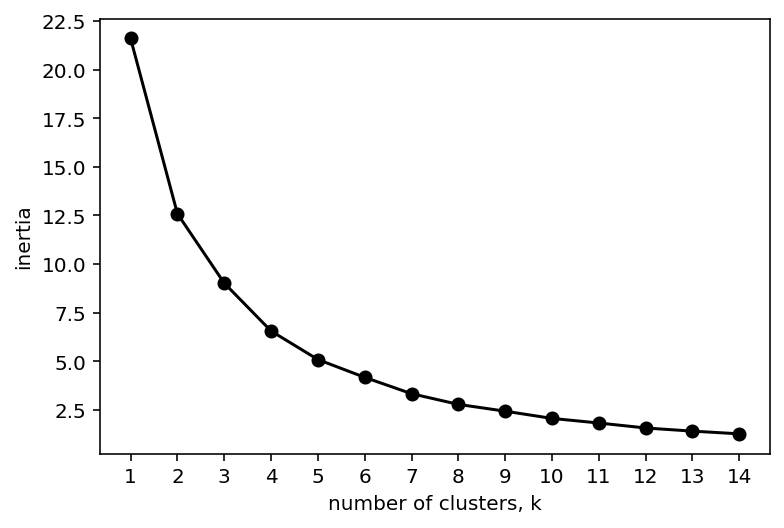

In [0]:
#@@@@@
ks = range(1, 15)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(processedVit.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)

In [0]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans.fit(processedVit)
df_kmeans = pd.concat([reduced_df.reset_index(drop = True), pd.DataFrame(processedVit)], axis = 1)
df_kmeans.columns.values[-3:] = ['Component 1', 'Compenent 2', 'Component 3']
df_kmeans['K-Means'] = kmeans.labels_

##### T-SNE

In [0]:
''' prepare the features for be analyszed '''
X = processedVit[vit_features].values
result_tsne = TSNE(n_components=2,perplexity=50).fit_transform(X)

In [0]:
vits_tsne_df = pd.DataFrame(data=result_tsne, columns=['x','y'])

alt.Chart(vits_tsne_df).mark_point().encode(
    x='x:Q',
    y='y:Q',
)

alt.Chart(...)

In [0]:
vits_tsne_df['Cluster'] = df_kmeans['K-Means']
vits_tsne_df['Food_Group'] = reduced_df['FdGrp_Desc']
vits_tsne_df['Food_Description'] = df['Shrt_Desc']
vits_tsne_df['ID'] = df["NDB_No"]

In [0]:
tsne1 = alt.Chart(vits_tsne_df).mark_circle().encode(
    x='x:Q',
    y='y:Q',
    color='Cluster:N',
    tooltip=['Cluster', 'Food_Group', 'Food_Description']
)
tsne1

alt.Chart(...)

In [0]:
tsne2 = alt.Chart(vits_tsne_df).mark_circle().encode(
    x='x:Q',
    y='y:Q',
    color='Food_Group:N',
    tooltip=['Cluster', 'Food_Group', 'Food_Description']
)
tsne2

alt.Chart(...)

#### TSNE -> Kmeans

([<matplotlib.axis.XTick at 0x7ff5b3c53cf8>,
 <a list of 14 Text major ticklabel objects>)

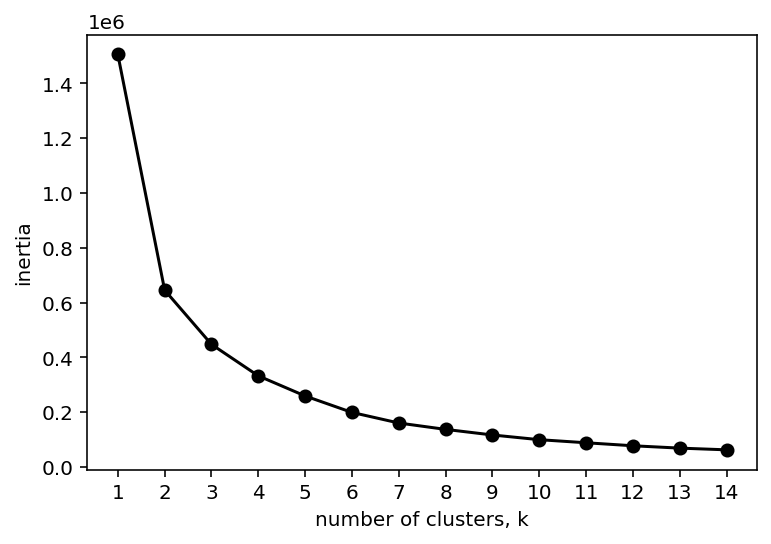

In [0]:
tsne_df_2 = pd.DataFrame(data=result_tsne, columns=['x','y'])
#@@@@@
ks = range(1, 15)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(tsne_df_2.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)

In [0]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans.fit(tsne_df_2)
df_kmeans2 = pd.concat([reduced_df.reset_index(drop = True), pd.DataFrame(tsne_df_2)], axis = 1)
df_kmeans2.columns.values[-3:] = ['Component 1', 'Compenent 2', 'Component 3']
tsne_df_2['K-Means'] = kmeans.labels_
tsne_df_2

x          y  K-Means
0     -9.220412 -24.164906        0
1     -9.219696 -24.166035        0
2     -9.199781 -24.255497        0
3    -10.011436  12.428598        2
4     -8.810182  11.858534        2
...         ...        ...      ...
1831   5.720151 -25.142126        0
1832  -2.028641 -34.634003        0
1833  18.963270   6.692390        1
1834  21.141352   8.570969        1
1835  21.252422  15.742824        1

[1836 rows x 3 columns]

In [0]:
tsne_df_2['Cluster'] = tsne_df_2['K-Means']
tsne_df_2['Food_Group'] = reduced_df['FdGrp_Desc']
tsne_df_2['Food_Description'] = df['Shrt_Desc']

In [0]:
tsne3 = alt.Chart(tsne_df_2).mark_circle().encode(
    x='x:Q',
    y='y:Q',
    color='K-Means:N',
    tooltip=['Cluster', 'Food_Group', 'Food_Description']
)

In [0]:
tsne1 | tsne2 | tsne3

alt.HConcatChart(...)

In [0]:
test = tsne_df_2[['Cluster', 'Food_Group']]
check = test.groupby('Food_Group')['Cluster'].value_counts().reset_index(name='Counts')

#### Non-Dominating Clusters:

In [0]:
alt.Chart(check).mark_bar().encode(
    y=alt.X('Food_Group', sort='-y'),
    x=alt.Y('Counts', stack='normalize'),
    color='Cluster:N'
)

alt.Chart(...)

In [0]:
vit_cluster = processedVit.copy()
vit_cluster['cluster'] = tsne_df_2['Cluster']
vit_cluster['group'] = reduced_df['FdGrp_Desc']
vit_cluster['description'] = reduced_df['Shrt_Desc']
vit_cluster['ID'] = reduced_df['NDB_No']
vit_cluster

Vit_C    Vit_B6  ...                                        description     ID
0       0.0  0.000509  ...                                   BUTTER,WITH SALT   1001
1       0.0  0.000509  ...                           BUTTER,WHIPPED,WITH SALT   1002
2       0.0  0.000170  ...                               BUTTER OIL,ANHYDROUS   1003
3       0.0  0.028140  ...                                        CHEESE,BLUE   1004
4       0.0  0.011019  ...                                       CHEESE,BRICK   1005
...     ...       ...  ...                                                ...    ...
1831    0.0  0.002882  ...                SALAD DRSNG,MAYO DRSNG,DIET,NO CHOL  43599
1832    0.0  0.000000  ...                          OIL,CORN,PEANUT,AND OLIVE  44005
1833    0.0  0.006781  ...           PUDDINGS,CHOC FLAVOR,LO CAL,INST,DRY MIX  44061
1834    0.0  0.004577  ...            PUDDINGS,CHOC FLAVOR,LO CAL,REG,DRY MIX  44258
1835    0.0  0.000848  ...  PUDDINGS,ALL FLAVORS XCPT CHOC,LO CAL,INST,DRY...  44260

[1836 rows x 13 columns]

In [0]:
vit_cluster.columns

Index(['Vit_C', 'Vit_B6', 'Vit_B12', 'Vit_A_IU', 'Vit_A_RAE', 'Vit_E', 'Vit_D',
       'Vit_D.1', 'Vit_K', 'cluster', 'group', 'description', 'ID'],
      dtype='object')

In [0]:
vit_cluster.columns

Index(['Vit_C', 'Vit_B6', 'Vit_B12', 'Vit_A_IU', 'Vit_A_RAE', 'Vit_E', 'Vit_D',
       'Vit_D.1', 'Vit_K', 'cluster', 'group', 'description', 'ID'],
      dtype='object')

In [0]:
vit_soup = vit_cluster[vit_cluster['group'] == 'Soups, Sauces, and Gravies']
vit_bake = vit_cluster[vit_cluster['group'] == 'Baked Products']
vit_meals = vit_cluster[vit_cluster['group'] == 'Meals']
vit_leg = vit_cluster[vit_cluster['group'] == 'Legumes and Legume Products']

In [0]:
px.parallel_coordinates(vit_soup, color='cluster', dimensions=['cluster', 'Vit_C', 'Vit_B6', 'Vit_B12', 'Vit_A_IU', 'Vit_A_RAE', 'Vit_E', 'Vit_D',
       'Vit_D.1', 'Vit_K'], 
                         color_continuous_scale=[(0.00, "blue"),   (0.25, "blue"),
                                                (0.25, "goldenrod"), (0.5, "goldenrod"),
                                                (0.5, "red"),  (.75, "red"),
                                                (0.75,"green"),(1,"green")],)

In [0]:
px.parallel_coordinates(vit_bake, color='cluster', dimensions=['cluster', 'Vit_C', 'Vit_B6', 'Vit_B12', 'Vit_A_IU', 'Vit_A_RAE', 'Vit_E', 'Vit_D',
       'Vit_D.1', 'Vit_K'], 
                         color_continuous_scale=[(0.00, "blue"),   (0.25, "blue"),
                                                (0.25, "goldenrod"), (0.5, "goldenrod"),
                                                (0.5, "red"),  (.75, "red"),
                                                (0.75,"green"),(1,"green")],)

In [0]:
px.parallel_coordinates(vit_meals, color='cluster', dimensions=['cluster', 'Vit_C', 'Vit_B6', 'Vit_B12', 'Vit_A_IU', 'Vit_A_RAE', 'Vit_E', 'Vit_D',
       'Vit_D.1', 'Vit_K'], 
                         color_continuous_scale=[(0.00, "blue"),   (0.25, "blue"),
                                                (0.25, "goldenrod"), (0.5, "goldenrod"),
                                                (0.5, "red"),  (.75, "red"),
                                                (0.75,"green"),(1,"green")],)

In [0]:
px.parallel_coordinates(vit_leg, color='cluster', dimensions=['cluster', 'Vit_C', 'Vit_B6', 'Vit_B12', 'Vit_A_IU', 'Vit_A_RAE', 'Vit_E', 'Vit_D',
       'Vit_D.1', 'Vit_K'], 
                         color_continuous_scale=[(0.00, "blue"),   (0.25, "blue"),
                                                (0.25, "goldenrod"), (0.5, "goldenrod"),
                                                (0.5, "red"),  (.75, "red"),
                                                (0.75,"green"),(1,"green")],)

In [0]:
vit_soup.columns

Index(['Vit_C', 'Vit_B6', 'Vit_B12', 'Vit_A_IU', 'Vit_A_RAE', 'Vit_E', 'Vit_D',
       'Vit_D.1', 'Vit_K', 'cluster', 'group', 'description', 'ID'],
      dtype='object')

In [0]:
vit_soup_list=[]

vit_soup_list.extend(vit_soup[(vit_soup['Vit_A_IU']>.05)]['ID'].tolist())
vit_soup_list.extend(vit_soup[(vit_soup['Vit_D']>.04)]['ID'].tolist())
vit_soup_list.extend(vit_soup[(vit_soup['Vit_B6']>.09)]['ID'].tolist())
vit_soup_list.extend(vit_soup[(vit_soup['Vit_B12']>.45)]['ID'].tolist())
print(vit_soup_list)

[6068, 6071, 6165, 6166, 6167, 6094, 6030]


In [0]:
vit_bake_list=[]

vit_bake_list.extend(vit_bake[(vit_bake['Vit_A_RAE']>.08)]['ID'].tolist())
vit_bake_list.extend(vit_bake[(vit_bake['Vit_C']>.006)]['ID'].tolist())
print(vit_bake_list)

[18288, 18326, 18403, 18933, 18095]


In [0]:
vit_meals_list=[]

vit_meals_list.extend(vit_meals[(vit_meals['Vit_B12']>.04)]['ID'].tolist())
vit_meals_list.extend(vit_meals[(vit_meals['Vit_A_IU']>.15)]['ID'].tolist())
print(vit_meals_list)

[36012, 22953]


In [0]:
vit_leg_list=[]

vit_leg_list.extend(vit_leg[(vit_leg['Vit_A_IU']>.003)]['ID'].tolist())
print(vit_leg_list)

[16059, 16085, 16139]


In [0]:

vits_outliers = vit_soup_list  + vit_bake_list +  vit_meals_list + vit_leg_list
vits_out = vit_cluster[vit_cluster['ID'].isin(vits_outliers)]
vits_out[['cluster', 'group', 'description']]

cluster  ...                                        description
331         2  ...             SOUP,CLAM CHOWDER,NEW ENGLAND,CND,COND
345         0  ...                       SOUP,VEGETARIAN VEG,CND,COND
347         0  ...                               SOUP,VEG BF,CND,COND
351         2  ...                                 SOUP,ONION,DRY,MIX
361         2  ...                          SAUCE,HOMEMADE,WHITE,THIN
362         2  ...                           SAUCE,HOMEMADE,WHITE,MED
363         2  ...                         SAUCE,HOMEMADE,WHITE,THICK
1266        0  ...                            CHILI WITH BEANS,CANNED
1274        0  ...                        PEAS,SPLIT,MATURE SEEDS,RAW
1298        2  ...  SOYMILK,ORIGINAL & VANILLA,W/ ADDED CA,VITAMIN...
1414        1  ...                    CAKE,CHERRY FUDGE W/CHOC FRSTNG
1517        2  ...         PANCAKES PLN,FRZ,RTH (INCLUDES BUTTERMILK)
1531        0  ...                            PIE,PUMPKIN,COMMLY PREP
1563        2  ...                WAFFLES,PLN,FRZ,READY -TO-HEAT,TSTD
1572        2  ...                        WAFFLE,BTTRMLK,FRZ,RTH,TSTD
1732        0  ...                            EGG ROLLS,PORK,REFR,HTD
1805        1  ...      RESTAURANT,FAMILY STYLE,FRIED MOZZARELLA STKS

[17 rows x 3 columns]

#### Minorities of Non-Dominating Clusters

In [0]:
produce = processed_cluster[processed_cluster['group'] == 'Produce']
fish = processed_cluster[processed_cluster['group'] == 'Finfish and Shellfish Products']
fakemeat = processed_cluster[processed_cluster['group'] == 'Sausages and Luncheon Meats']
babyfood = processed_cluster[processed_cluster['group'] == 'Baby Foods']
nut = processed_cluster[processed_cluster['group'] == 'Nut and Seed Products']

In [0]:
px.parallel_coordinates(produce, color='cluster', dimensions=['cluster','group','Vit_C', 'Thiamin',
       'Riboflavin', 'Niacin', 'Panto_Acid', 'Vit_B6', 'Folate_Tot.',
       'Folic_Acid', 'Food_Folate', 'Folate_DFE', 'Choline_Tot', 'Vit_B12',
       'Vit_A_IU', 'Vit_A_RAE', 'Retinol', 'Vit_E', 'Vit_D', 'Vit_D.1'], 
                         color_continuous_scale=[(0.00, "red"),   (0.25, "red"),
                                                (0.25, "green"), (0.5, "green"),
                                                (0.5, "blue"),  (.75, "blue"),
                                                (0.75,"goldenrod"),(1,"goldenrod")],)

In [0]:
MeatIDList=[]
MeatIDList.extend(produce[produce['Riboflavin']>0.8]['ID'].tolist())
MeatIDList.extend(produce[produce['Folic_Acid']>0.007]['ID'].tolist())
MeatOutliers = produce[produce.ID.isin(MeatIDList)]
MeatOutliers

In [0]:
px.parallel_coordinates(fish, color='cluster', dimensions=['cluster','group','Vit_C', 'Thiamin',
       'Riboflavin', 'Niacin', 'Panto_Acid', 'Vit_B6', 'Folate_Tot.',
       'Folic_Acid', 'Food_Folate', 'Folate_DFE', 'Choline_Tot', 'Vit_B12',
       'Vit_A_IU', 'Vit_A_RAE', 'Retinol', 'Vit_E', 'Vit_D', 'Vit_D.1'], 
                         color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)

In [0]:
MeatIDList=[]
MeatIDList.extend(fish[fish['cluster']>0.75]['ID'].tolist())
MeatOutliers = fish[fish.ID.isin(MeatIDList)]
MeatOutliers

In [0]:
px.parallel_coordinates(fakemeat, color='cluster', dimensions=['cluster','group','Vit_C', 'Thiamin',
       'Riboflavin', 'Niacin', 'Panto_Acid', 'Vit_B6', 'Folate_Tot.',
       'Folic_Acid', 'Food_Folate', 'Folate_DFE', 'Choline_Tot', 'Vit_B12',
       'Vit_A_IU', 'Vit_A_RAE', 'Retinol', 'Vit_E', 'Vit_D', 'Vit_D.1'], 
                         color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)

In [0]:
MeatIDList=[]
MeatIDList.extend(fakemeat[fakemeat['cluster']>0.75]['ID'].tolist())
MeatOutliers = fakemeat[fakemeat.ID.isin(MeatIDList)]
MeatOutliers

In [0]:
px.parallel_coordinates(babyfood, color='cluster', dimensions=['cluster','group','Vit_C', 'Thiamin',
       'Riboflavin', 'Niacin', 'Panto_Acid', 'Vit_B6', 'Folate_Tot.',
       'Folic_Acid', 'Food_Folate', 'Folate_DFE', 'Choline_Tot', 'Vit_B12',
       'Vit_A_IU', 'Vit_A_RAE', 'Retinol', 'Vit_E', 'Vit_D', 'Vit_D.1'], 
                         color_continuous_scale=[(0.00, "red"),   (0.25, "red"),
                                                (0.25, "green"), (0.5, "green"),
                                                (0.5, "blue"),  (.75, "blue"),
                                                (0.75,"goldenrod"),(1,"goldenrod")],)

In [0]:
MeatIDList=[]
MeatIDList.extend(babyfood[babyfood['Riboflavin']>0.7]['ID'].tolist())
MeatOutliers = babyfood[babyfood.ID.isin(MeatIDList)]
MeatOutliers

In [0]:
px.parallel_coordinates(nut, color='cluster', dimensions=['cluster','group','Vit_C', 'Thiamin',
       'Riboflavin', 'Niacin', 'Panto_Acid', 'Vit_B6', 'Folate_Tot.',
       'Folic_Acid', 'Food_Folate', 'Folate_DFE', 'Choline_Tot', 'Vit_B12',
       'Vit_A_IU', 'Vit_A_RAE', 'Retinol', 'Vit_E', 'Vit_D', 'Vit_D.1'], 
                         color_continuous_scale=[(0.00, "red"),   (0.25, "red"),
                                                (0.25, "green"), (0.5, "green"),
                                                (0.5, "blue"),  (.75, "blue"),
                                                (0.75,"goldenrod"),(1,"goldenrod")],)

In [0]:
MeatIDList=[]
MeatIDList.extend(nut[(nut['cluster']==0) | (nut['cluster']==2)]['ID'].tolist())
MeatOutliers = nut[nut.ID.isin(MeatIDList)]
MeatOutliers

## Set 3

In [0]:
copied_tsne = tsne_df.copy()
copied_tsne['description'] = df['Shrt_Desc']
copied_tsne['Vit_C'] = vitamin_distribution['Vit_C']
copied_tsne['Vit_B6'] = vitamin_distribution['Vit_B6']
copied_tsne['Vit_B12'] = vitamin_distribution['Vit_B12']
copied_tsne['Vit_A_IU'] = vitamin_distribution['Vit_A_IU']
copied_tsne['Vit_A_RAE'] = vitamin_distribution['Vit_A_RAE']
copied_tsne['Vit_E'] = vitamin_distribution['Vit_E']
copied_tsne['Vit_D'] = vitamin_distribution['Vit_D']
copied_tsne['Vit_D.1'] = vitamin_distribution['Vit_D.1']
copied_tsne['Vit_K'] = vitamin_distribution['Vit_K']
copied_tsne['Sodium'] = minerals_distribution['Sodium']
copied_tsne['Potassium'] = minerals_distribution['Potassium']
copied_tsne['Manganese'] = minerals_distribution['Manganese']
copied_tsne['Zinc'] = minerals_distribution['Zinc']
copied_tsne['Calcium'] = minerals_distribution['Calcium']
copied_tsne['Iron'] = minerals_distribution['Iron']
copied_tsne['Phosphorus'] = minerals_distribution['Phosphorus']
copied_tsne['Magnesium'] = minerals_distribution['Magnesium']
copied_tsne['Copper'] = minerals_distribution['Copper']

In [0]:
superfoods = copied_tsne[copied_tsne['description'].str.contains('KALE') | copied_tsne['description'].str.contains('GINGER') | copied_tsne['description'].str.contains('BEETS') | copied_tsne['description'].str.contains('SWEET POTATO') | copied_tsne['description'].str.contains('FLAX') | copied_tsne['description'].str.contains('FIG') | copied_tsne['description'].str.contains('SALMON')]
superfoods = superfoods[(~superfoods['description'].str.contains('PIE')) & (~superfoods['description'].str.contains('description')) & (~superfoods['description'].str.contains('CARBONATED')) & (~superfoods['description'].str.contains('MUFFIN')) & (~superfoods['description'].str.contains('COOKIE')) & (~superfoods['description'].str.contains('SYRUP')) & (~superfoods['description'].str.contains('LIQUID')) & (~superfoods['description'].str.contains('CAKE'))]
superfoods = superfoods[(~superfoods['description'].str.contains('BEET')) & (~superfoods['description'].str.contains('SWEET POTATO')) & (~superfoods['description'].str.contains('SOCKEYE')) & (~superfoods['description'].str.contains('CHUM')) & (~superfoods['description'].str.contains('PINK')) & (~superfoods['description'].str.contains('CHINOOK')) & (~superfoods['description'].str.contains('DRY')) & (~superfoods['description'].str.contains('GROUND')) & (~superfoods['description'].str.contains('DRIED'))]
superfoods = superfoods[(~superfoods['description'].str.contains('BEET')) & (~superfoods['description'].str.contains('SWEET POTATO')) & (~superfoods['description'].str.contains('SOCKEYE')) & (~superfoods['description'].str.contains('CHUM')) & (~superfoods['description'].str.contains('PINK')) & (~superfoods['description'].str.contains('CHINOOK')) & (~superfoods['description'].str.contains('DRY')) & (~superfoods['description'].str.contains('GROUND')) & (~superfoods['description'].str.contains('DRIED'))]
superfoods = superfoods.drop(['Food_Description', 'x', 'y'], axis=1)
superfoods

In [0]:
vits_miner0 = pd.concat([vitamin_distribution, minerals_distribution], axis=1)
vits_miner0 = vits_miner0.drop(['Outlier'], axis=1)
vits_miner0 = vits_miner0.loc[:,~vits_miner0.columns.duplicated()]
clust = vits_miner0['Cluster']
vits_miner0.drop(labels=['Cluster'], axis=1, inplace = True)
vits_miner0.insert(0, 'Cluster', clust)
vits_miner0 = vits_miner0[vits_miner0['Cluster'] == 0] 
vits_miner0['super_status'] = 0

vits_miner2 = pd.concat([vitamin_distribution, minerals_distribution], axis=1)
vits_miner2 = vits_miner2.drop(['Outlier'], axis=1)
vits_miner2 = vits_miner2.loc[:,~vits_miner2.columns.duplicated()]
clust = vits_miner2['Cluster']
vits_miner2.drop(labels=['Cluster'], axis=1, inplace = True)
vits_miner2.insert(0, 'Cluster', clust)
vits_miner2 = vits_miner2[vits_miner2['Cluster'] == 2] 
vits_miner2['super_status'] = 0
vits_miner2

vits_miner3 = pd.concat([vitamin_distribution, minerals_distribution], axis=1)
vits_miner3 = vits_miner3.drop(['Outlier'], axis=1)
vits_miner3 = vits_miner3.loc[:,~vits_miner3.columns.duplicated()]
clust = vits_miner3['Cluster']
vits_miner3.drop(labels=['Cluster'], axis=1, inplace = True)
vits_miner3.insert(0, 'Cluster', clust)
vits_miner3 = vits_miner3[vits_miner3['Cluster'] == 3] 
vits_miner3['super_status'] = 0

Salmon

In [0]:
sf_salmon = superfoods[superfoods['description'].str.contains('SALMON')]
sf_salmon['super_status'] = 1
sf_salmon = sf_salmon.drop(['Food_Group', 'description'], axis=1)

In [0]:
sf_salmon_c = sf_salmon.append(vits_miner0)

In [0]:
sf_salmon_g = copied_tsne.copy()
sf_salmon_g = sf_salmon_g.drop(['x', 'y', 'Food_Description', 'description'], axis=1)
sf_salmon_g['super_status'] = 0
sf_salmon_g = sf_salmon_g[sf_salmon_g['Food_Group'] == 'Finfish and Shellfish Products'] 
sf_salmon_g = sf_salmon_g.drop(columns=['Food_Group'])
sf_salmon_g = sf_salmon.append(sf_salmon_g)

In [0]:
sf_salmon_cg = sf_salmon_c.merge(sf_salmon_g, how='inner')

In [0]:
#vitamins
salmon_vc = px.parallel_coordinates(sf_salmon_c, color='super_status', dimensions=['super_status', 'Vit_C', 'Vit_B6', 'Vit_B12', 'Vit_A_IU', 'Vit_A_RAE', 'Vit_E', 'Vit_D', 'Vit_D.1', 'Vit_K'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
salmon_vg = px.parallel_coordinates(sf_salmon_g, color='super_status', dimensions=['super_status', 'Vit_C', 'Vit_B6', 'Vit_B12', 'Vit_A_IU', 'Vit_A_RAE', 'Vit_E', 'Vit_D', 'Vit_D.1', 'Vit_K'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
salmon_vcg = px.parallel_coordinates(sf_salmon_cg, color='super_status', dimensions=['super_status', 'Vit_C', 'Vit_B6', 'Vit_B12', 'Vit_A_IU', 'Vit_A_RAE', 'Vit_E', 'Vit_D', 'Vit_D.1', 'Vit_K'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
#minerals
salmon_mc = px.parallel_coordinates(sf_salmon_c, color='super_status', dimensions=['super_status', 'Sodium', 'Potassium', 'Manganese', 'Zinc', 'Calcium', 'Iron', 'Phosphorus', 'Magnesium', 'Copper'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
salmon_mg = px.parallel_coordinates(sf_salmon_g, color='super_status', dimensions=['super_status', 'Sodium', 'Potassium', 'Manganese', 'Zinc', 'Calcium', 'Iron', 'Phosphorus', 'Magnesium', 'Copper'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
salmon_mcg = px.parallel_coordinates(sf_salmon_cg, color='super_status', dimensions=['super_status', 'Sodium', 'Potassium', 'Manganese', 'Zinc', 'Calcium', 'Iron', 'Phosphorus', 'Magnesium', 'Copper'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)

Fig

In [0]:
sf_fig = superfoods[superfoods['description'].str.contains('FIG')]
sf_fig['super_status'] = 1
sf_fig = sf_fig.drop(['Food_Group', 'description'], axis=1)
sf_fig_c = sf_fig.append(vits_miner2)
sf_fig_g = copied_tsne.copy()
sf_fig_g = sf_fig_g.drop(['x', 'y', 'Food_Description', 'description'], axis=1)
sf_fig_g['super_status'] = 0
sf_fig_g = sf_fig_g[sf_fig_g['Food_Group'] == 'Produce'] 
sf_fig_g = sf_fig_g.drop(columns=['Food_Group'])
sf_fig_g = sf_fig.append(sf_fig_g)
sf_fig_cg = sf_fig_c.merge(sf_fig_g, how='inner')

#vitamins
fig_vc = px.parallel_coordinates(sf_fig_c, color='super_status', dimensions=['super_status', 'Vit_C', 'Vit_B6', 'Vit_B12', 'Vit_A_IU', 'Vit_A_RAE', 'Vit_E', 'Vit_D', 'Vit_D.1', 'Vit_K'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
fig_vg = px.parallel_coordinates(sf_fig_g, color='super_status', dimensions=['super_status', 'Vit_C', 'Vit_B6', 'Vit_B12', 'Vit_A_IU', 'Vit_A_RAE', 'Vit_E', 'Vit_D', 'Vit_D.1', 'Vit_K'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
fig_vcg = px.parallel_coordinates(sf_fig_cg, color='super_status', dimensions=['super_status', 'Vit_C', 'Vit_B6', 'Vit_B12', 'Vit_A_IU', 'Vit_A_RAE', 'Vit_E', 'Vit_D', 'Vit_D.1', 'Vit_K'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
#minerals
fig_mc = px.parallel_coordinates(sf_fig_c, color='super_status', dimensions=['super_status', 'Sodium', 'Potassium', 'Manganese', 'Zinc', 'Calcium', 'Iron', 'Phosphorus', 'Magnesium', 'Copper'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
fig_mg = px.parallel_coordinates(sf_fig_g, color='super_status', dimensions=['super_status', 'Sodium', 'Potassium', 'Manganese', 'Zinc', 'Calcium', 'Iron', 'Phosphorus', 'Magnesium', 'Copper'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
fig_mcg = px.parallel_coordinates(sf_fig_cg, color='super_status', dimensions=['super_status', 'Sodium', 'Potassium', 'Manganese', 'Zinc', 'Calcium', 'Iron', 'Phosphorus', 'Magnesium', 'Copper'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)

ginger

In [0]:
sf_ginger = superfoods[superfoods['description'].str.contains('GINGER')]
sf_ginger['super_status'] = 1
sf_ginger = sf_ginger.drop(['Food_Group', 'description'], axis=1)
sf_ginger_c = sf_ginger.append(vits_miner2)
sf_ginger_g = copied_tsne.copy()
sf_ginger_g = sf_ginger_g.drop(['x', 'y', 'Food_Description', 'description'], axis=1)
sf_ginger_g['super_status'] = 0
sf_ginger_g = sf_ginger_g[sf_ginger_g['Food_Group'] == 'Produce'] 
sf_ginger_g = sf_ginger_g.drop(columns=['Food_Group'])
sf_ginger_g = sf_ginger.append(sf_ginger_g)
sf_ginger_cg = sf_ginger_c.merge(sf_ginger_g, how='inner')

#vitamins
ginger_vc = px.parallel_coordinates(sf_ginger_c, color='super_status', dimensions=['super_status', 'Vit_C', 'Vit_B6', 'Vit_B12', 'Vit_A_IU', 'Vit_A_RAE', 'Vit_E', 'Vit_D', 'Vit_D.1', 'Vit_K'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
ginger_vg = px.parallel_coordinates(sf_ginger_g, color='super_status', dimensions=['super_status', 'Vit_C', 'Vit_B6', 'Vit_B12', 'Vit_A_IU', 'Vit_A_RAE', 'Vit_E', 'Vit_D', 'Vit_D.1', 'Vit_K'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
ginger_vcg = px.parallel_coordinates(sf_ginger_cg, color='super_status', dimensions=['super_status', 'Vit_C', 'Vit_B6', 'Vit_B12', 'Vit_A_IU', 'Vit_A_RAE', 'Vit_E', 'Vit_D', 'Vit_D.1', 'Vit_K'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
#minerals
ginger_mc = px.parallel_coordinates(sf_ginger_c, color='super_status', dimensions=['super_status', 'Sodium', 'Potassium', 'Manganese', 'Zinc', 'Calcium', 'Iron', 'Phosphorus', 'Magnesium', 'Copper'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
ginger_mg = px.parallel_coordinates(sf_ginger_g, color='super_status', dimensions=['super_status', 'Sodium', 'Potassium', 'Manganese', 'Zinc', 'Calcium', 'Iron', 'Phosphorus', 'Magnesium', 'Copper'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
ginger_mcg = px.parallel_coordinates(sf_ginger_cg, color='super_status', dimensions=['super_status', 'Sodium', 'Potassium', 'Manganese', 'Zinc', 'Calcium', 'Iron', 'Phosphorus', 'Magnesium', 'Copper'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)

kale

In [0]:
sf_kale = superfoods[superfoods['description'].str.contains('KALE')]
sf_kale['super_status'] = 1
sf_kale = sf_kale.drop(['Food_Group', 'description'], axis=1)
sf_kale_c = sf_kale.append(vits_miner2)
sf_kale_g = copied_tsne.copy()
sf_kale_g = sf_kale_g.drop(['x', 'y', 'Food_Description', 'description'], axis=1)
sf_kale_g['super_status'] = 0
sf_kale_g = sf_kale_g[sf_kale_g['Food_Group'] == 'Produce'] 
sf_kale_g = sf_kale_g.drop(columns=['Food_Group'])
sf_kale_g = sf_kale.append(sf_kale_g)
sf_kale_cg = sf_kale_c.merge(sf_kale_g, how='inner')

#vitamins
kale_vc = px.parallel_coordinates(sf_kale_c, color='super_status', dimensions=['super_status', 'Vit_C', 'Vit_B6', 'Vit_B12', 'Vit_A_IU', 'Vit_A_RAE', 'Vit_E', 'Vit_D', 'Vit_D.1', 'Vit_K'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
kale_vg = px.parallel_coordinates(sf_kale_g, color='super_status', dimensions=['super_status', 'Vit_C', 'Vit_B6', 'Vit_B12', 'Vit_A_IU', 'Vit_A_RAE', 'Vit_E', 'Vit_D', 'Vit_D.1', 'Vit_K'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
kale_vcg = px.parallel_coordinates(sf_kale_cg, color='super_status', dimensions=['super_status', 'Vit_C', 'Vit_B6', 'Vit_B12', 'Vit_A_IU', 'Vit_A_RAE', 'Vit_E', 'Vit_D', 'Vit_D.1', 'Vit_K'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
#minerals
kale_mc = px.parallel_coordinates(sf_kale_c, color='super_status', dimensions=['super_status', 'Sodium', 'Potassium', 'Manganese', 'Zinc', 'Calcium', 'Iron', 'Phosphorus', 'Magnesium', 'Copper'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
kale_mg = px.parallel_coordinates(sf_kale_g, color='super_status', dimensions=['super_status', 'Sodium', 'Potassium', 'Manganese', 'Zinc', 'Calcium', 'Iron', 'Phosphorus', 'Magnesium', 'Copper'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
kale_mcg = px.parallel_coordinates(sf_kale_cg, color='super_status', dimensions=['super_status', 'Sodium', 'Potassium', 'Manganese', 'Zinc', 'Calcium', 'Iron', 'Phosphorus', 'Magnesium', 'Copper'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)

flaxseed

In [0]:
sf_flax = superfoods[superfoods['description'].str.contains('FLAX')]
sf_flax['super_status'] = 1
sf_flax = sf_flax.drop(['Food_Group', 'description'], axis=1)
sf_flax_c = sf_flax.append(vits_miner3)
sf_flax_g = copied_tsne.copy()
sf_flax_g = sf_flax_g.drop(['x', 'y', 'Food_Description', 'description'], axis=1)
sf_flax_g['super_status'] = 0
sf_flax_g = sf_flax_g[sf_flax_g['Food_Group'] == 'Nut and Seed Products'] 
sf_flax_g = sf_flax_g.drop(columns=['Food_Group'])
sf_flax_g = sf_flax.append(sf_flax_g)
sf_flax_cg = sf_flax_c.merge(sf_flax_g, how='inner')

#vitamins
flax_vc = px.parallel_coordinates(sf_flax_c, color='super_status', dimensions=['super_status', 'Vit_C', 'Vit_B6', 'Vit_B12', 'Vit_A_IU', 'Vit_A_RAE', 'Vit_E', 'Vit_D', 'Vit_D.1', 'Vit_K'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
flax_vg = px.parallel_coordinates(sf_flax_g, color='super_status', dimensions=['super_status', 'Vit_C', 'Vit_B6', 'Vit_B12', 'Vit_A_IU', 'Vit_A_RAE', 'Vit_E', 'Vit_D', 'Vit_D.1', 'Vit_K'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
flax_vcg = px.parallel_coordinates(sf_flax_cg, color='super_status', dimensions=['super_status', 'Vit_C', 'Vit_B6', 'Vit_B12', 'Vit_A_IU', 'Vit_A_RAE', 'Vit_E', 'Vit_D', 'Vit_D.1', 'Vit_K'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
#minerals
flax_mc = px.parallel_coordinates(sf_flax_c, color='super_status', dimensions=['super_status', 'Sodium', 'Potassium', 'Manganese', 'Zinc', 'Calcium', 'Iron', 'Phosphorus', 'Magnesium', 'Copper'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
flax_mg = px.parallel_coordinates(sf_flax_g, color='super_status', dimensions=['super_status', 'Sodium', 'Potassium', 'Manganese', 'Zinc', 'Calcium', 'Iron', 'Phosphorus', 'Magnesium', 'Copper'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
flax_mcg = px.parallel_coordinates(sf_flax_cg, color='super_status', dimensions=['super_status', 'Sodium', 'Potassium', 'Manganese', 'Zinc', 'Calcium', 'Iron', 'Phosphorus', 'Magnesium', 'Copper'], 
                        color_continuous_scale=[(0.00, "red"), (0.50, "red"), (0.50, "blue"),  (1,"blue")],)
